# Baseline time series models (ARIMA, ETS, Prophet)

In [1]:
# Standard library
import logging
import warnings
from dataclasses import dataclass

# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Time series & statistics (statsmodels)
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Forecasting/ML libraries
from prophet import Prophet
from sklearn.linear_model import LinearRegression

# Warnings & logging configuration
warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.WARNING, force=True)

# Silence cmdstanpy/Prophet verbosity
for name in [
    "cmdstanpy",
    "cmdstanpy.model",
    "cmdstanpy.stanfit",
    "cmdstanpy.utils",
    "prophet",
]:
    logger = logging.getLogger(name)
    logger.setLevel(logging.WARNING)
    logger.propagate = False
    logger.handlers = [logging.NullHandler()]

## System-level daily models

For y_daily_system (2017–2022):

* ARIMA/SARIMA:

  * Differencing orders were identified using ACF/PACF diagnostics and unit root tests.
  * Exogenous regressors were incorporated, including temperature, precipitation, holiday/weekday/weekend indicators, and COVID phase variables.
  * ARIMA and SARIMAX specifications with seasonal components were compared to capture weekly and annual seasonality.

* ETS:

  * ETS models were fitted with trend and seasonal components where appropriate.

* Prophet:

  * Built-in yearly, weekly, and daily seasonality components were employed.
  * Additional regressors were included, such as temperature, precipitation, holidays, and pandemic regime indicators.
  * Prophet’s decomposition outputs were used to support interpretability and diagnostic visualization.

In [2]:
BASE = "/Users/zoltanjelovich/Documents/ISEG/MFW/data"
Y_PATH = f"{BASE}/targets/system/y_daily_system.parquet"
X_PATH = f"{BASE}/features/system/X_daily_system.parquet"

# Load and filter to 2017–2022
y = pd.read_parquet(Y_PATH)[["date", "trips"]].copy()
x = pd.read_parquet(X_PATH).copy()

y["date"] = pd.to_datetime(y["date"])
x["date"] = pd.to_datetime(x["date"])

mask = (y["date"] >= "2017-01-01") & (y["date"] <= "2022-12-31")
y = y.loc[mask].sort_values("date").reset_index(drop=True)
x = x.loc[(x["date"] >= "2017-01-01") & (x["date"] <= "2022-12-31")].sort_values("date").reset_index(drop=True)

# Inner join ensures perfect alignment on dates used for modeling diagnostics
df = y.merge(x, on="date", how="inner", suffixes=("_y", "_x"))

# Target series
ts = df.set_index("date")["trips_y"].asfreq("D")

# Sanity checks
print(ts.index.min(), ts.index.max(), ts.shape)
print("Missing dates:", ts.isna().sum())

# Define exogenous regressors for later SARIMAX
EXOG_COLS = [
    "temp_avg_f",
    "precip_inches",
    "is_holiday",
    "is_weekend",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]
missing = [c for c in EXOG_COLS if c not in df.columns]
print("Missing exog cols:", missing)

# Build exog frame
exog = df.set_index("date")[EXOG_COLS].copy()

# Ensure numeric dtypes
for c in exog.columns:
    if exog[c].dtype == "bool":
        exog[c] = exog[c].astype(int)

print(exog.dtypes)

# Unit root tests
def adf_test(series, name="series"):
    s = series.dropna()
    res = adfuller(s, autolag="AIC")
    out = {"test": "ADF", "series": name, "stat": res[0], "p": res[1], "lags": res[2], "nobs": res[3]}
    return out

def kpss_test(series, name="series", regression="c"):
    # regression="c" tests level-stationarity; "ct" tests trend-stationarity
    s = series.dropna()
    stat, p, lags, crit = kpss(s, regression=regression, nlags="auto")
    out = {"test": f"KPSS({regression})", "series": name, "stat": stat, "p": p, "lags": lags}
    return out

tests = []
tests.append(adf_test(ts, "y"))
tests.append(kpss_test(ts, "y", "c"))
tests.append(kpss_test(ts, "y", "ct"))

# Candidate differenced series
ts_d1 = ts.diff(1)
ts_D7 = ts.diff(7)
ts_d1_D7 = ts.diff(1).diff(7)

tests.append(adf_test(ts_d1, "y diff(1)"))
tests.append(kpss_test(ts_d1, "y diff(1)", "c"))

tests.append(adf_test(ts_D7, "y diff(7)"))
tests.append(kpss_test(ts_D7, "y diff(7)", "c"))

tests.append(adf_test(ts_d1_D7, "y diff(1),diff(7)"))
tests.append(kpss_test(ts_d1_D7, "y diff(1),diff(7)", "c"))

pd.DataFrame(tests)

2017-01-01 00:00:00 2022-12-31 00:00:00 (2191,)
Missing dates: 0
Missing exog cols: []
temp_avg_f          float64
precip_inches       float64
is_holiday            int64
is_weekend            int64
regime_pre_covid       int8
regime_covid           int8
regime_recovery        int8
dtype: object


,test,series,stat,p,lags,nobs
0,ADF,y,-2.497178,1.161624e-01,26,2164.0
1,KPSS(c),y,2.411058,1.000000e-02,28,NaN
2,KPSS(ct),y,0.150569,4.619283e-02,27,NaN
3,ADF,y diff(1),-12.031080,2.873161e-22,26,2163.0
4,KPSS(c),y diff(1),0.064177,1.000000e-01,121,NaN
5,ADF,y diff(7),-9.936342,2.737302e-17,23,2160.0
6,KPSS(c),y diff(7),0.075604,1.000000e-01,15,NaN
7,ADF,"y diff(1),diff(7)",-14.892838,1.548013e-27,26,2156.0
8,KPSS(c),"y diff(1),diff(7)",0.007158,1.000000e-01,23,NaN


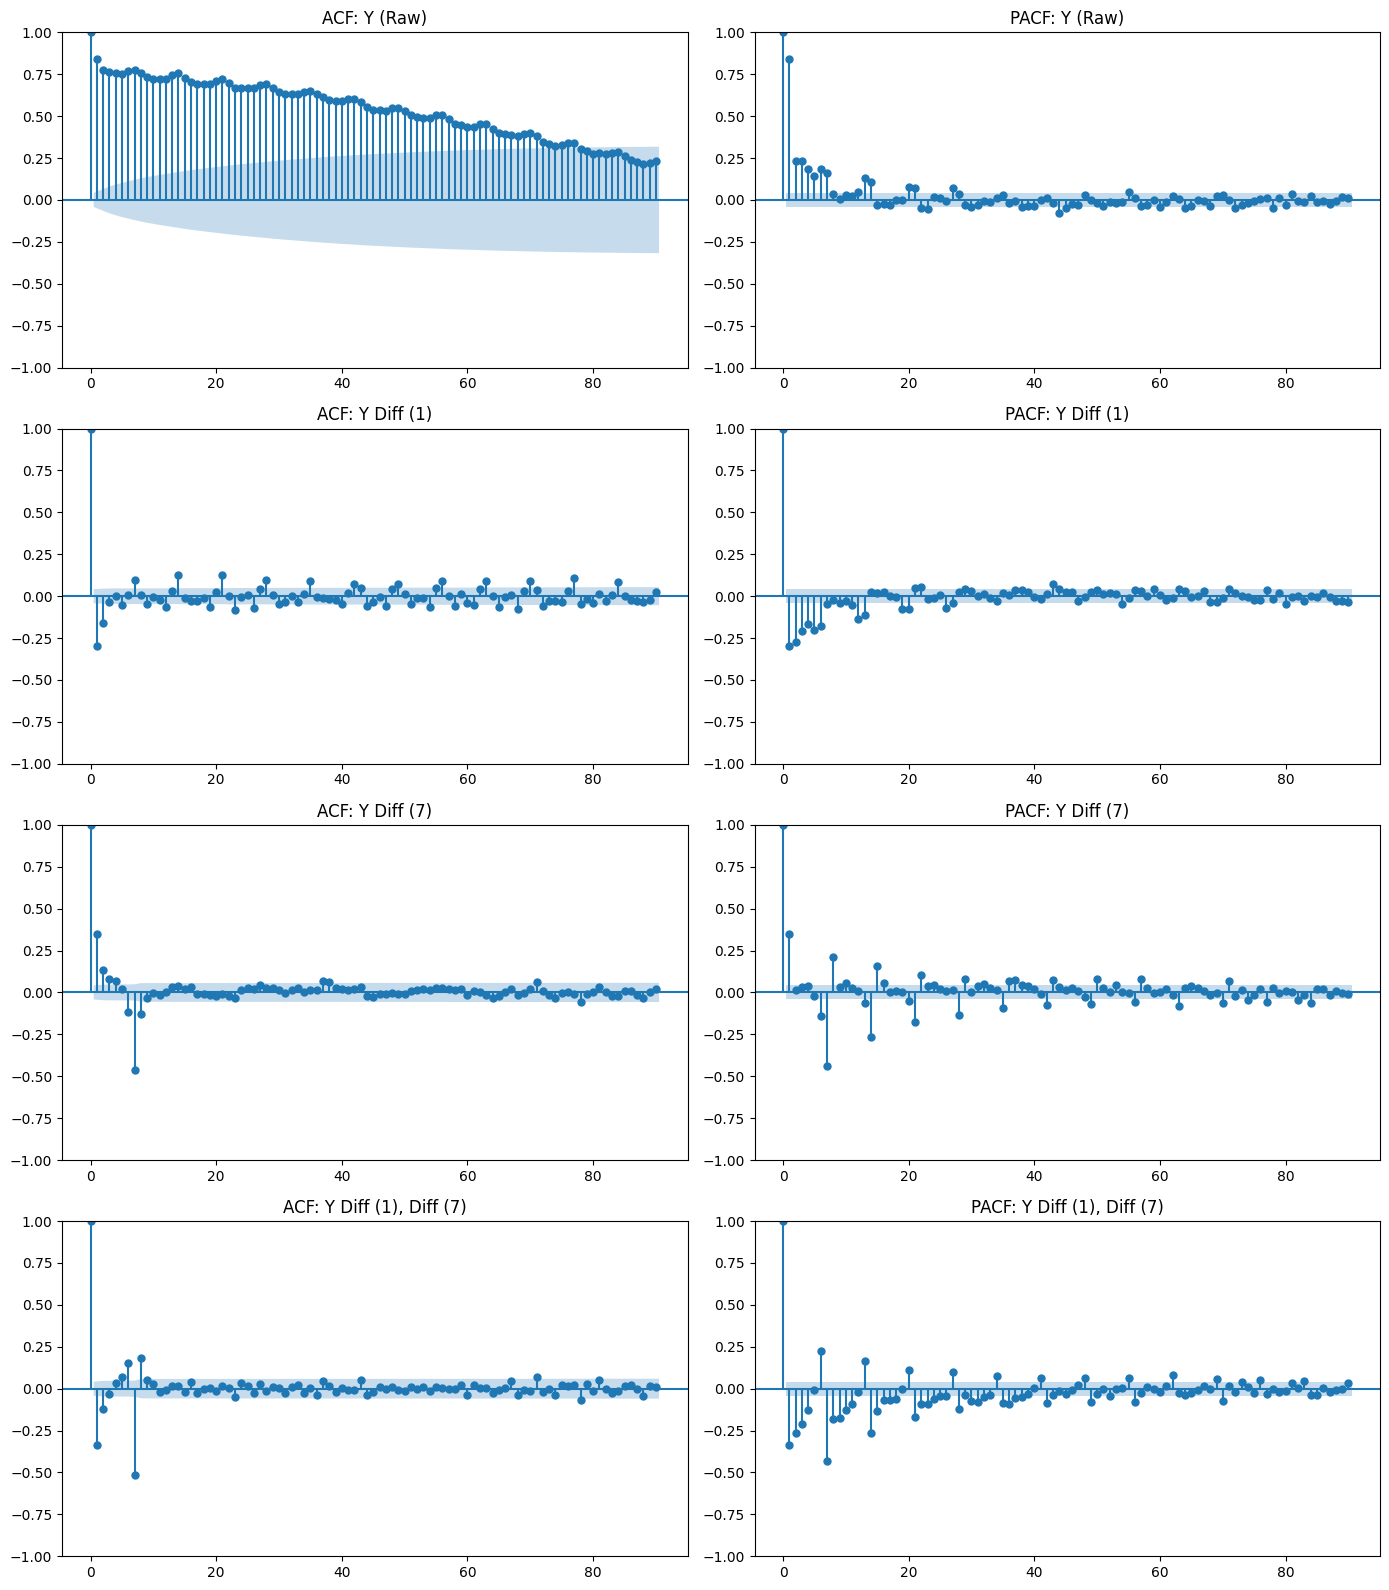

In [3]:
# ACF/PACF diagnostics for differencing choice
def acf_pacf_grid(series_dict, lags=60):
    n = len(series_dict)
    fig, axes = plt.subplots(n, 2, figsize=(14, 4*n))
    if n == 1:
        axes = np.array([axes])

    for i, (name, s) in enumerate(series_dict.items()):
        s = s.dropna()
        plot_acf(s, lags=lags, ax=axes[i, 0])
        axes[i, 0].set_title(f"ACF: {name}")
        plot_pacf(s, lags=lags, ax=axes[i, 1], method="ywm")
        axes[i, 1].set_title(f"PACF: {name}")

    plt.tight_layout()
    plt.show()

series_to_check = {
    "Y (Raw)": ts,
    "Y Diff (1)": ts_d1,
    "Y Diff (7)": ts_D7,
    "Y Diff (1), Diff (7)": ts_d1_D7,
}

acf_pacf_grid(series_to_check, lags=90)

In [4]:
# Reuse ts from earlier cell
y = ts.copy()

def fit_sarimax(y, order, seasonal_order, exog=None, trend="n"):
    model = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        exog=exog,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    return res

def summarize_model(res, name):
    resid = res.resid.dropna()
    lb = acorr_ljungbox(resid, lags=[7, 14, 21], return_df=True)
    out = {
        "model": name,
        "order": res.model.order,
        "seasonal_order": res.model.seasonal_order,
        "AIC": res.aic,
        "BIC": res.bic,
        "LB_p(7)": float(lb.loc[7, "lb_pvalue"]),
        "LB_p(14)": float(lb.loc[14, "lb_pvalue"]),
        "LB_p(21)": float(lb.loc[21, "lb_pvalue"]),
    }
    return out

results = []

# Non-seasonal ARIMA baselines (ignore seasonality)
arima_candidates = [
    ((0,1,1), (0,0,0,0)),
    ((1,1,0), (0,0,0,0)),
    ((1,1,1), (0,0,0,0)),
]

for order, seas in arima_candidates:
    res = fit_sarimax(y, order=order, seasonal_order=seas, exog=None, trend="n")
    results.append(summarize_model(res, f"ARIMA{order}"))

# Seasonal SARIMA baselines (weekly seasonality)
sarima_candidates = [
    ((0,0,1), (0,1,1,7)),
    ((1,0,0), (0,1,1,7)),
    ((1,0,1), (0,1,1,7)),
    ((0,0,1), (1,1,1,7)),
    ((1,0,1), (1,1,1,7)),
]

for order, seas in sarima_candidates:
    res = fit_sarimax(y, order=order, seasonal_order=seas, exog=None, trend="n")
    results.append(summarize_model(res, f"SARIMA{order}x{seas}"))

pd.DataFrame(results).sort_values(["BIC", "AIC"]).reset_index(drop=True)

,model,order,seasonal_order,AIC,BIC,LB_p(7),LB_p(14),LB_p(21)
0,"SARIMA(1, 0, 1)x(0, 1, 1, 7)","(1, 0, 1)","(0, 1, 1, 7)",47860.130680,47882.869816,1.477909e-14,1.093426e-12,1.020590e-10
1,"SARIMA(1, 0, 1)x(1, 1, 1, 7)","(1, 0, 1)","(1, 1, 1, 7)",47859.439328,47887.863247,2.660017e-14,3.800071e-12,4.107156e-10
2,"ARIMA(1, 1, 1)","(1, 1, 1)","(0, 0, 0, 0)",47959.147748,47976.219978,9.800906e-07,8.761619e-17,1.407606e-25
3,"SARIMA(1, 0, 0)x(0, 1, 1, 7)","(1, 0, 0)","(0, 1, 1, 7)",48037.173293,48054.229024,6.049858e-24,8.741437e-44,1.174759e-54
4,"ARIMA(0, 1, 1)","(0, 1, 1)","(0, 0, 0, 0)",48095.535952,48106.917438,2.149417e-37,1.491697e-56,5.747716e-73
5,"SARIMA(0, 0, 1)x(1, 1, 1, 7)","(0, 0, 1)","(1, 1, 1, 7)",48137.289184,48160.028320,3.682792e-71,6.086602e-96,7.288130e-105
6,"SARIMA(0, 0, 1)x(0, 1, 1, 7)","(0, 0, 1)","(0, 1, 1, 7)",48143.258678,48160.313030,7.635656e-73,1.675759e-100,3.151976e-113
7,"ARIMA(1, 1, 0)","(1, 1, 0)","(0, 0, 0, 0)",48441.725417,48453.107817,2.530152e-54,6.448702e-68,8.933776e-82


In [5]:
y = ts.copy()

def try_fit(order, seasonal_order, exog=None):
    try:
        mod = SARIMAX(
            y, order=order, seasonal_order=seasonal_order, exog=exog,
            trend="n", enforce_stationarity=False, enforce_invertibility=False
        )
        res = mod.fit(disp=False)
        resid = res.resid.dropna()
        lb = acorr_ljungbox(resid, lags=[7,14,21], return_df=True)
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "AIC": res.aic,
            "BIC": res.bic,
            "LB_p(7)": float(lb.loc[7, "lb_pvalue"]),
            "LB_p(14)": float(lb.loc[14, "lb_pvalue"]),
            "LB_p(21)": float(lb.loc[21, "lb_pvalue"]),
            "converged": bool(getattr(res, "mle_retvals", {}).get("converged", True))
        }
    except Exception as e:
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "AIC": np.nan,
            "BIC": np.nan,
            "LB_p(7)": np.nan,
            "LB_p(14)": np.nan,
            "LB_p(21)": np.nan,
            "converged": False,
            "error": str(e)[:120]
        }

# Primary differencing decision
d, D, s = 0, 1, 7

p_vals = [0, 1, 2]
q_vals = [0, 1, 2]
P_vals = [0, 1]
Q_vals = [0, 1, 2]

rows = []
for p in p_vals:
    for q in q_vals:
        for P in P_vals:
            for Q in Q_vals:
                order = (p, d, q)
                seas = (P, D, Q, s)
                rows.append(try_fit(order, seas))

grid = pd.DataFrame(rows)
grid_ok = grid.dropna(subset=["BIC"]).sort_values(["BIC", "AIC"]).reset_index(drop=True)

grid_ok.head(15)

,order,seasonal_order,AIC,BIC,LB_p(7),LB_p(14),LB_p(21),converged
0,"(1, 0, 2)","(0, 1, 2, 7)",47642.289180,47676.375774,9.580079e-01,9.470072e-01,9.825791e-01,True
1,"(1, 0, 2)","(1, 1, 2, 7)",47642.357313,47682.125006,9.649133e-01,9.837084e-01,9.834118e-01,True
2,"(2, 0, 2)","(0, 1, 2, 7)",47643.483197,47683.250890,9.973459e-01,9.821434e-01,9.935716e-01,True
3,"(2, 0, 2)","(1, 1, 2, 7)",47643.648034,47689.096826,9.978327e-01,9.959555e-01,9.932153e-01,False
4,"(2, 0, 1)","(0, 1, 2, 7)",47662.376105,47696.465467,8.917449e-01,9.171656e-01,9.698286e-01,True
5,"(2, 0, 1)","(1, 1, 2, 7)",47662.598971,47702.369893,8.866419e-01,9.603008e-01,9.663382e-01,True
6,"(1, 0, 1)","(0, 1, 2, 7)",47707.576566,47735.984367,2.414345e-14,2.688968e-12,2.945057e-10,True
7,"(1, 0, 1)","(1, 1, 2, 7)",47707.969934,47742.059296,2.383560e-14,8.883489e-12,4.194227e-10,True
8,"(1, 0, 2)","(0, 1, 1, 7)",47793.651631,47822.073251,8.748132e-01,8.841996e-01,9.573558e-01,True
9,"(1, 0, 2)","(1, 1, 1, 7)",47794.659672,47828.765616,9.595347e-01,9.552565e-01,9.858212e-01,True


In [6]:
y = ts.copy()

# Calendar + COVID only
EXOG_CAL_COVID = [
    "is_weekend",
    "is_holiday",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

X_cal = df.set_index("date")[EXOG_CAL_COVID].copy()

# Ensure numeric
for c in X_cal.columns:
    if X_cal[c].dtype == "bool":
        X_cal[c] = X_cal[c].astype(int)

# Align perfectly
y_aligned, X_cal_aligned = y.align(X_cal, join="inner", axis=0)

assert y_aligned.isna().sum() == 0
assert X_cal_aligned.isna().sum().sum() == 0

# Fit baseline SARIMA (no exog)
order = (1, 0, 1)
seasonal_order = (0, 1, 1, 7)

def fit_model(y, order, seasonal_order, exog=None, name="model"):
    mod = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        exog=exog,
        trend="n",
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = mod.fit(disp=False)
    resid = res.resid.dropna()
    lb = acorr_ljungbox(resid, lags=[7, 14, 21], return_df=True)
    summary = {
        "model": name,
        "order": order,
        "seasonal_order": seasonal_order,
        "nobs": int(res.nobs),
        "AIC": float(res.aic),
        "BIC": float(res.bic),
        "LB_p(7)": float(lb.loc[7, "lb_pvalue"]),
        "LB_p(14)": float(lb.loc[14, "lb_pvalue"]),
        "LB_p(21)": float(lb.loc[21, "lb_pvalue"]),
        "converged": bool(getattr(res, "mle_retvals", {}).get("converged", True)),
    }
    return res, summary

res_base, base_stats = fit_model(
    y_aligned, order, seasonal_order, exog=None, name="SARIMA baseline (no exog)"
)

# Fit SARIMAX with calendar + COVID
res_cal, cal_stats = fit_model(
    y_aligned, order, seasonal_order, exog=X_cal_aligned, name="SARIMAX + calendar + COVID"
)

# Compare model-level diagnostics
compare = pd.DataFrame([base_stats, cal_stats])
compare

,model,order,seasonal_order,nobs,AIC,BIC,LB_p(7),LB_p(14),LB_p(21),converged
0,SARIMA baseline (no exog),"(1, 0, 1)","(0, 1, 1, 7)",2191,47860.130680,47882.869816,1.477909e-14,1.093426e-12,1.020590e-10,True
1,SARIMAX + calendar + COVID,"(1, 0, 1)","(0, 1, 1, 7)",2191,47852.551187,47903.714242,9.416356e-15,1.034622e-12,1.099512e-10,True


In [7]:
# Coefficient table for the SARIMAX + calendar + COVID model
params = res_cal.params
bse = res_cal.bse
tvals = params / bse

coef_table = pd.DataFrame({
    "coef": params,
    "std_err": bse,
    "t_value": tvals,
}).sort_index()

# Show just the exogenous coefficients first, then the ARMA terms
exog_rows = [r for r in coef_table.index if r in EXOG_CAL_COVID]
arma_rows = [r for r in coef_table.index if r not in exog_rows]

coef_table.loc[exog_rows + arma_rows]

,coef,std_err,t_value
is_holiday,-1.017692e+04,2216.465394,-4.591508e+00
is_weekend,3.339712e-07,9306.825204,3.588455e-11
regime_covid,2.283143e+04,37347.570496,6.113230e-01
regime_pre_covid,1.169143e+04,29813.145935,3.921568e-01
regime_recovery,2.798643e+04,42899.006847,6.523794e-01
ar.L1,9.821704e-01,0.007772,1.263748e+02
ma.L1,-7.144561e-01,0.021332,-3.349158e+01
ma.S.L7,-9.404868e-01,0.012196,-7.711237e+01
sigma2,3.162406e+08,13.388437,2.362043e+07


In [8]:
# Reuse df and ts from earlier steps
y = ts.copy()

order = (1, 0, 1)
seasonal_order = (0, 1, 1, 7)

def fit_model(y, order, seasonal_order, exog=None, name="model"):
    mod = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        exog=exog,
        trend="n",
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = mod.fit(disp=False)
    resid = res.resid.dropna()
    lb = acorr_ljungbox(resid, lags=[7, 14, 21], return_df=True)
    summary = {
        "model": name,
        "order": order,
        "seasonal_order": seasonal_order,
        "nobs": int(res.nobs),
        "AIC": float(res.aic),
        "BIC": float(res.bic),
        "LB_p(7)": float(lb.loc[7, "lb_pvalue"]),
        "LB_p(14)": float(lb.loc[14, "lb_pvalue"]),
        "LB_p(21)": float(lb.loc[21, "lb_pvalue"]),
        "converged": bool(getattr(res, "mle_retvals", {}).get("converged", True)),
    }
    return res, summary

# Exog block (calendar + COVID)
EXOG_CAL_COVID = [
    "is_weekend",
    "is_holiday",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

X2 = df.set_index("date")[EXOG_CAL_COVID].copy()
for c in X2.columns:
    if X2[c].dtype == "bool":
        X2[c] = X2[c].astype(int)

# Exog block (calendar + COVID + weather)
EXOG_WEATHER = ["temp_avg_f", "precip_inches"]
EXOG_STEP3 = EXOG_CAL_COVID + EXOG_WEATHER

X3 = df.set_index("date")[EXOG_STEP3].copy()
for c in X3.columns:
    if X3[c].dtype == "bool":
        X3[c] = X3[c].astype(int)

# Align to y
y2, X2 = y.align(X2, join="inner", axis=0)
y3, X3 = y.align(X3, join="inner", axis=0)

assert y2.isna().sum() == 0 and X2.isna().sum().sum() == 0
assert y3.isna().sum() == 0 and X3.isna().sum().sum() == 0

res_step2, stats_step2 = fit_model(
    y2, order, seasonal_order, exog=X2, name="SARIMAX + calendar + COVID"
)

res_step3, stats_step3 = fit_model(
    y3, order, seasonal_order, exog=X3, name="SARIMAX + calendar + COVID + weather"
)

compare = pd.DataFrame([stats_step2, stats_step3])
compare

,model,order,seasonal_order,nobs,AIC,BIC,LB_p(7),LB_p(14),LB_p(21),converged
0,SARIMAX + calendar + COVID,"(1, 0, 1)","(0, 1, 1, 7)",2191,47852.551187,47903.714242,9.416356e-15,1.034622e-12,1.099512e-10,True
1,SARIMAX + calendar + COVID + weather,"(1, 0, 1)","(0, 1, 1, 7)",2191,46477.883876,46540.416499,3.730338e-09,1.075796e-08,4.132566e-08,True


In [9]:
# Coefficient table
params = res_step3.params
bse = res_step3.bse
tvals = params / bse

coef_table = pd.DataFrame({
    "coef": params,
    "std_err": bse,
    "t_value": tvals,
}).sort_index()

# Show exogenous coefficients first, then ARMA terms
exog_rows = [r for r in EXOG_STEP3 if r in coef_table.index]
arma_rows = [r for r in coef_table.index if r not in exog_rows]

coef_table.loc[exog_rows + arma_rows]

,coef,std_err,t_value
is_weekend,-1.316175e-06,11086.710620,-1.187164e-10
is_holiday,-1.126540e+04,1488.707485,-7.567236e+00
regime_pre_covid,7.024373e+03,9101.257259,7.718025e-01
regime_covid,1.749958e+04,14408.159104,1.214560e+00
regime_recovery,2.156332e+04,18714.406683,1.152231e+00
temp_avg_f,8.185736e+02,57.524951,1.422989e+01
precip_inches,-2.089952e+04,275.288356,-7.591865e+01
ar.L1,9.569896e-01,0.012921,7.406722e+01
ma.L1,-6.749622e-01,0.026445,-2.552287e+01
ma.S.L7,-9.041888e-01,0.014311,-6.318192e+01


In [10]:
y = ts.copy()

def fit_ets(y, error, trend, seasonal, damped=False, seasonal_periods=7, name="ETS"):
    model = ExponentialSmoothing(
        y,
        trend=trend,
        damped_trend=damped if trend is not None else False,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        initialization_method="estimated"
    )
    res = model.fit(optimized=True)
    
    resid = res.resid.dropna()
    lb = acorr_ljungbox(resid, lags=[7,14,21], return_df=True)
    
    return {
        "model": name,
        "error": error,
        "trend": trend if trend else "None",
        "seasonal": seasonal,
        "damped": damped,
        "AIC": res.aic,
        "BIC": res.bic,
        "LB_p(7)": float(lb.loc[7, "lb_pvalue"]),
        "LB_p(14)": float(lb.loc[14, "lb_pvalue"]),
        "LB_p(21)": float(lb.loc[21, "lb_pvalue"]),
    }

rows = []

rows.append(fit_ets(y, "A", None, "add", False, name="ETS(A,N,A)"))
rows.append(fit_ets(y, "A", "add", "add", False, name="ETS(A,A,A)"))
rows.append(fit_ets(y, "A", "add", "add", True,  name="ETS(A,Ad,A)"))

rows.append(fit_ets(y, "M", None, "add", False, name="ETS(M,N,A)"))
rows.append(fit_ets(y, "M", "add", "add", False, name="ETS(M,A,A)"))
rows.append(fit_ets(y, "M", "add", "add", True,  name="ETS(M,Ad,A)"))

ets_results = pd.DataFrame(rows).sort_values(["BIC", "AIC"]).reset_index(drop=True)
ets_results

,model,error,trend,seasonal,damped,AIC,BIC,LB_p(7),LB_p(14),LB_p(21)
0,"ETS(A,N,A)",A,None,add,False,41724.479070,41775.708090,1.071996e-17,8.109015e-16,9.495867e-14
1,"ETS(M,N,A)",M,None,add,False,41724.479070,41775.708090,1.071996e-17,8.109015e-16,9.495867e-14
2,"ETS(A,Ad,A)",A,add,add,True,41736.326933,41804.632293,2.263246e-18,9.690601e-16,2.431342e-13
3,"ETS(M,Ad,A)",M,add,add,True,41736.326933,41804.632293,2.263246e-18,9.690601e-16,2.431342e-13
4,"ETS(A,A,A)",A,add,add,False,41758.381787,41820.995034,1.886666e-20,4.650588e-18,1.284809e-15
5,"ETS(M,A,A)",M,add,add,False,41758.381787,41820.995034,1.886666e-20,4.650588e-18,1.284809e-15


In [11]:
# Prepare Prophet dataframe

prophet_df = df.copy()

prophet_df = prophet_df.rename(columns={
    "date": "ds",
    "trips_y": "y"
})

# Keep only needed columns
REGRESSORS = [
    "temp_avg_f",
    "precip_inches",
    "is_holiday",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

prophet_df = prophet_df[["ds", "y"] + REGRESSORS].copy()

# Ensure correct dtypes
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])
prophet_df["y"] = prophet_df["y"].astype(float)

for c in REGRESSORS:
    prophet_df[c] = prophet_df[c].astype(float)

# Define Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
)

# Add regressors
for reg in REGRESSORS:
    m.add_regressor(reg)

# Fit model
m.fit(prophet_df)

# Store fitted model for later use
prophet_model = m

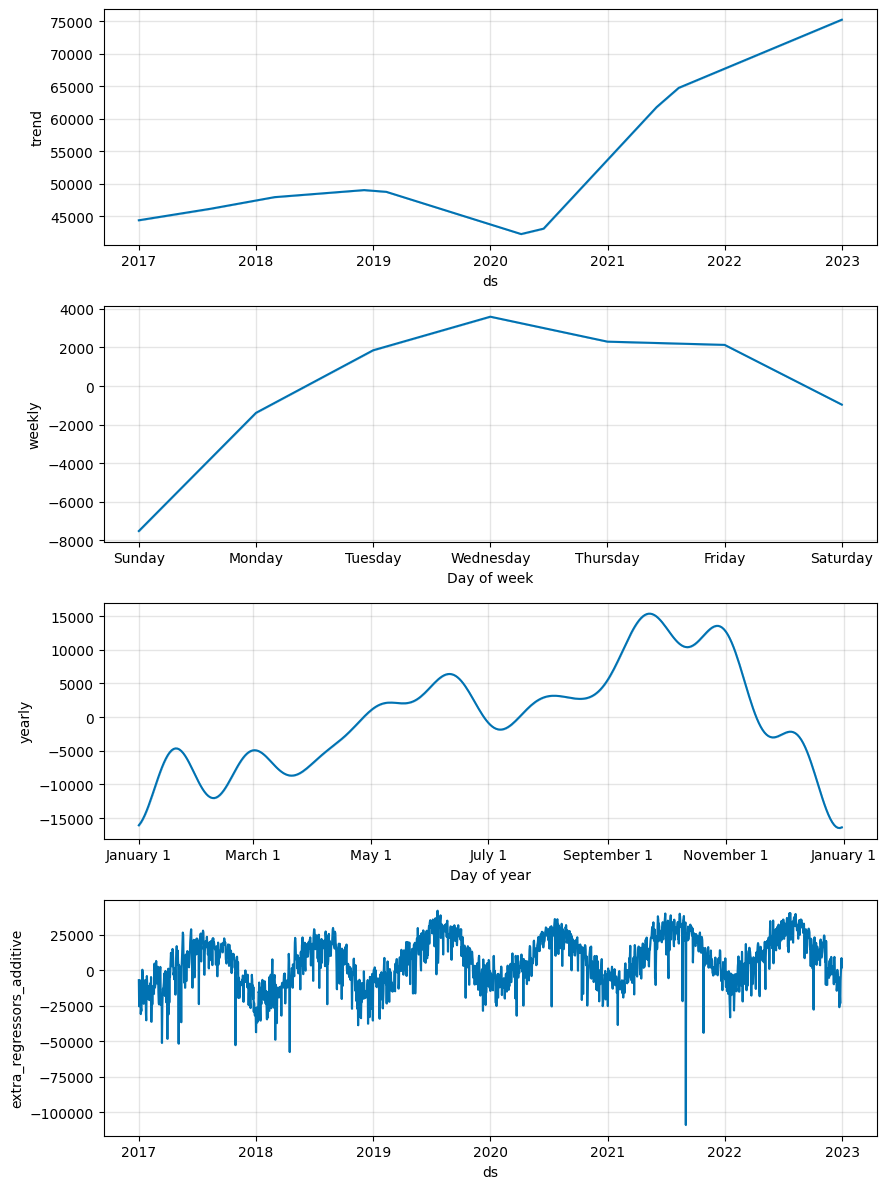

In [12]:
# Build a "future" dataframe that includes the same regressors
future = prophet_model.make_future_dataframe(periods=0, freq="D")

# Merge regressors onto future by date
reg_cols = [
    "temp_avg_f",
    "precip_inches",
    "is_holiday",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]
future = future.merge(prophet_df[["ds"] + reg_cols], on="ds", how="left")

# Safety checks
assert future[reg_cols].isna().sum().sum() == 0, "Missing regressor values in 'future'"

# Predict to generate trend/seasonality component columns
fcst = prophet_model.predict(future)

# Plot components (this now works)
prophet_model.plot_components(fcst);

In [13]:
prophet_model.params["beta"]

array([[-0.0509822 , -0.038764  , -0.0191383 , -0.0323246 ,  0.0233615 ,
        -0.00784734,  0.00244203, -0.00525483,  0.00166202, -0.00041257,
         0.00301634, -0.00335587,  0.00559848,  0.0032061 , -0.00256306,
        -0.0150487 ,  0.00558971, -0.0113385 ,  0.00390328, -0.00852131,
        -0.0138896 ,  0.0290627 ,  0.00973371, -0.0113044 , -0.00934342,
        -0.0006835 ,  0.107034  , -0.0533258 , -0.0679998 ,  0.0810223 ,
         0.0496186 ,  0.0824037 ]])

In [14]:
m = prophet_model
# The order of betas corresponds to this sorted list
reg_names = list(m.extra_regressors.keys())

beta = m.params["beta"][0]

rows = []
for name, b in zip(reg_names, beta):
    info = m.extra_regressors[name]
    mu = info.get("mu", 0.0)
    std = info.get("std", 1.0)
    coef_trips_per_unit = b * m.y_scale / std
    rows.append({
        "regressor": name,
        "beta_raw": b,
        "reg_std": std,
        "coef_trips_per_unit": coef_trips_per_unit
    })

coef_df = pd.DataFrame(rows).sort_values("coef_trips_per_unit")
coef_df

,regressor,beta_raw,reg_std,coef_trips_per_unit
1,precip_inches,-0.038764,0.349402,-14971.882345
3,regime_pre_covid,-0.032325,1.000000,-4362.204770
2,is_holiday,-0.019138,1.000000,-2582.713585
5,regime_recovery,-0.007847,1.000000,-1058.998533
0,temp_avg_f,-0.050982,16.955916,-405.760900
4,regime_covid,0.023362,1.000000,3152.634425


In [15]:
spike_row = fcst.loc[fcst["extra_regressors_additive"].idxmin(), ["ds", "extra_regressors_additive"]]
spike_row

ds                           2021-09-01 00:00:00
extra_regressors_additive          -109112.94648
Name: 1704, dtype: object

In [16]:
spike_date = spike_row["ds"]
prophet_df.loc[prophet_df["ds"] == spike_date, ["ds"] + list(m.extra_regressors.keys())]

,ds,temp_avg_f,precip_inches,is_holiday,regime_pre_covid,regime_covid,regime_recovery
1704,2021-09-01,73.5,6.669,0.0,0.0,0.0,1.0


## Station- and cluster-level time series baselines

For a selected subset:

* High-demand stations and cluster-level aggregates:

  * SARIMA and Prophet models were fitted to `y_daily_station` and `y_daily_cluster` series to:

    * Provide interpretable baseline models at finer spatial scales.
    * Examine differences in seasonal structure across station types.

In [17]:
DATA_ROOT = "/Users/zoltanjelovich/Documents/ISEG/MFW/data"

CLUSTER_DAILY_PATH = f"{DATA_ROOT}/targets/cluster/y_daily_cluster.parquet"
STATION_DAILY_PATH = f"{DATA_ROOT}/targets/station/y_daily_station.parquet"

# Column names
DATE_COL = "date"

CLUSTER_ID_COL = "cluster_id"
CLUSTER_TARGET_COL = "departures"

STATION_ID_COL = "station_id"
STATION_TARGET_COL = "departures"

dfc = pd.read_parquet(CLUSTER_DAILY_PATH)

required_cluster = {DATE_COL, CLUSTER_ID_COL, CLUSTER_TARGET_COL}
missing = required_cluster - set(dfc.columns)
if missing:
    raise KeyError(f"Missing required columns in {CLUSTER_DAILY_PATH}: {missing}")

dfc[DATE_COL] = pd.to_datetime(dfc[DATE_COL])
dfc = dfc.sort_values([CLUSTER_ID_COL, DATE_COL]).reset_index(drop=True)

print("Clusters found:", sorted(dfc[CLUSTER_ID_COL].unique().tolist()))
print("Date range:", dfc[DATE_COL].min(), "→", dfc[DATE_COL].max())
print("Target summary (departures):")
print(dfc[CLUSTER_TARGET_COL].describe())

Clusters found: [0, 1, 2]
Date range: 2017-01-01 00:00:00 → 2024-12-31 00:00:00
Target summary (departures):
count      7836.000000
mean      24671.626085
std       25806.356785
min          14.000000
25%        5416.000000
50%       14015.000000
75%       37843.250000
max      125592.000000
Name: departures, dtype: float64


In [18]:
def get_daily_series(
    df: pd.DataFrame,
    id_col: str,
    id_val,
    date_col: str,
    y_col: str,
) -> pd.Series:
    """
    Build a daily time series for a given entity (cluster_id or station_id).
    - Aggregates duplicates safely (sum)
    - Forces daily frequency
    - Fills missing dates via time interpolation + boundary fill
    - Does NOT fill missing with zeros (prevents artificial shutdown periods)
    """
    d = df.loc[df[id_col] == id_val, [date_col, y_col]].copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # Aggregate duplicate date rows safely
    s = d.groupby(date_col, as_index=True)[y_col].sum().sort_index()

    # Force daily frequency
    s = s.asfreq("D")

    # Fill missing observations realistically
    s = s.interpolate(method="time").ffill().bfill()

    # Basic sanity check
    if (s < 0).any():
        raise ValueError("Negative values detected after interpolation/fill.")

    return s.astype(float)


def train_test_split_series(ts: pd.Series, test_days: int = 90):
    """
    Simple holdout split: last `test_days` are test, rest are train.
    Keeps your existing holdout approach for the cluster holdout plot.
    """
    if len(ts) <= test_days + 30:
        raise ValueError("Series too short for the requested holdout split.")
    train = ts.iloc[:-test_days]
    test = ts.iloc[-test_days:]
    return train, test


def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

In [19]:
# Cluster-level SARIMA baselines

cluster_ids = sorted(dfc[CLUSTER_ID_COL].unique().tolist())

ORDER = (1, 0, 1)
SEASONAL_ORDER = (1, 1, 1, 7)

sarima_cluster_results = []
sarima_cluster_forecasts = {}

for cid in cluster_ids:
    ts = get_daily_series(
        df=dfc,
        id_col=CLUSTER_ID_COL,
        id_val=cid,
        date_col=DATE_COL,
        y_col=CLUSTER_TARGET_COL,
    )

    train, test = train_test_split_series(ts, test_days=90)

    model = SARIMAX(
        train,
        order=ORDER,
        seasonal_order=SEASONAL_ORDER,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    pred = res.get_forecast(steps=len(test)).predicted_mean
    pred.index = test.index  # align

    sarima_cluster_results.append(
        {
            "cluster_id": cid,
            "order": ORDER,
            "seasonal_order": SEASONAL_ORDER,
            "aic": float(res.aic),
            "rmse": rmse(test.values, pred.values),
            "mae": mae(test.values, pred.values),
        }
    )

    sarima_cluster_forecasts[cid] = {
        "train": train,
        "test": test,
        "forecast": pred,
    }

pd.DataFrame(sarima_cluster_results).sort_values("rmse")

,cluster_id,order,seasonal_order,aic,rmse,mae
2,2,"(1, 0, 1)","(1, 1, 1, 7)",47425.751842,5286.232112,4023.792856
0,0,"(1, 0, 1)","(1, 1, 1, 7)",54012.163937,13343.191062,10203.666788
1,1,"(1, 0, 1)","(1, 1, 1, 7)",60621.860660,34625.296833,25928.059405


In [20]:
# Cluster-level Prophet baselines

prophet_cluster_results = []
prophet_cluster_forecasts = {}

for cid in cluster_ids:
    ts = get_daily_series(
        df=dfc,
        id_col=CLUSTER_ID_COL,
        id_val=cid,
        date_col=DATE_COL,
        y_col=CLUSTER_TARGET_COL,
    )

    train, test = train_test_split_series(ts, test_days=90)

    train_df = train.reset_index().rename(columns={DATE_COL: "ds", CLUSTER_TARGET_COL: "y"})
    test_df = test.reset_index().rename(columns={DATE_COL: "ds", CLUSTER_TARGET_COL: "y"})

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
    )
    m.fit(train_df)

    future = pd.DataFrame({"ds": test_df["ds"]})
    fcst = m.predict(future)
    yhat = fcst["yhat"].values

    prophet_cluster_results.append(
        {
            "cluster_id": cid,
            "rmse": rmse(test_df["y"].values, yhat),
            "mae": mae(test_df["y"].values, yhat),
        }
    )

    prophet_cluster_forecasts[cid] = {
        "train": train,
        "test": test,
        "forecast": pd.Series(yhat, index=test.index),
    }

pd.DataFrame(prophet_cluster_results).sort_values("rmse")

,cluster_id,rmse,mae
2,2,4072.802224,3219.311681
0,0,10291.072636,8258.519565
1,1,20549.071355,16654.469793


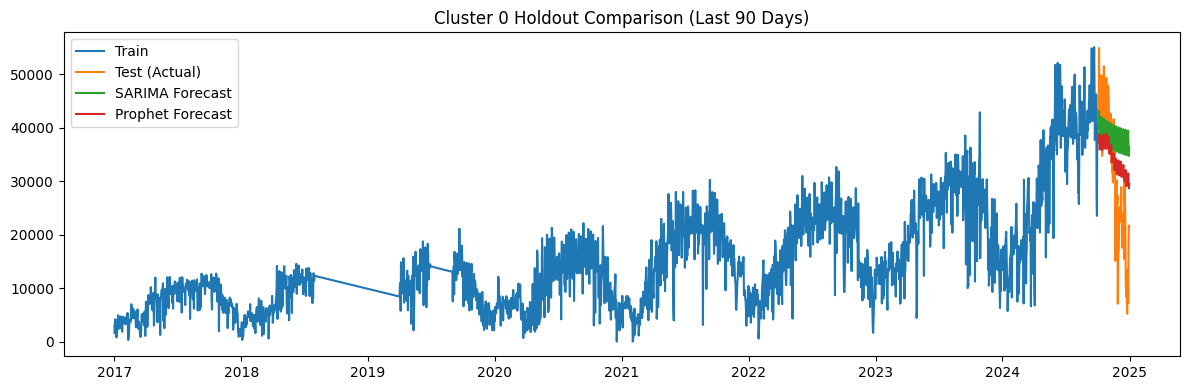

In [21]:
# Cluster 0 holdout plot

CLUSTER_TO_PLOT = 0

d_sarima = sarima_cluster_forecasts[CLUSTER_TO_PLOT]
d_prophet = prophet_cluster_forecasts[CLUSTER_TO_PLOT]

plt.figure(figsize=(12, 4))
plt.plot(d_sarima["train"].index, d_sarima["train"].values, label="Train")
plt.plot(d_sarima["test"].index, d_sarima["test"].values, label="Test (Actual)")
plt.plot(d_sarima["forecast"].index, d_sarima["forecast"].values, label="SARIMA Forecast")
plt.plot(d_prophet["forecast"].index, d_prophet["forecast"].values, label="Prophet Forecast")
plt.title(f"Cluster {CLUSTER_TO_PLOT} Holdout Comparison (Last 90 Days)")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Load station-level targets and select high-demand stations

dfs = pd.read_parquet(STATION_DAILY_PATH)

required_station = {DATE_COL, STATION_ID_COL, STATION_TARGET_COL}
missing = required_station - set(dfs.columns)
if missing:
    raise KeyError(f"Missing required columns in {STATION_DAILY_PATH}: {missing}")

dfs[DATE_COL] = pd.to_datetime(dfs[DATE_COL])
dfs = dfs.sort_values([STATION_ID_COL, DATE_COL]).reset_index(drop=True)

print("Date range:", dfs[DATE_COL].min(), "→", dfs[DATE_COL].max())
print("Stations:", dfs[STATION_ID_COL].nunique())

N_TOP = 10
top_stations = (
    dfs.groupby(STATION_ID_COL)[STATION_TARGET_COL]
    .mean()
    .sort_values(ascending=False)
    .head(N_TOP)
    .index
    .tolist()
)

top_stations

Date range: 2017-01-01 00:00:00 → 2024-12-31 00:00:00
Stations: 3547


['519',
 '6233.04',
 '6140.05',
 '6492.08',
 '5329.03',
 '497',
 '435',
 '5980.10',
 '402',
 '6822.09']

In [23]:
# Station-level SARIMA baselines

STATION_ORDER = (0, 0, 1)
STATION_SEASONAL_ORDER = (0, 1, 1, 7)

station_sarima_results = []

for sid in top_stations:
    ts = get_daily_series(
        df=dfs,
        id_col=STATION_ID_COL,
        id_val=sid,
        date_col=DATE_COL,
        y_col=STATION_TARGET_COL,
    )

    train, test = train_test_split_series(ts, test_days=90)

    model = SARIMAX(
        train,
        order=STATION_ORDER,
        seasonal_order=STATION_SEASONAL_ORDER,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    pred = res.get_forecast(steps=len(test)).predicted_mean
    pred.index = test.index

    station_sarima_results.append(
        {
            "station_id": sid,
            "rmse": rmse(test.values, pred.values),
            "mae": mae(test.values, pred.values),
            "aic": float(res.aic),
        }
    )

pd.DataFrame(station_sarima_results).sort_values("rmse")

,station_id,rmse,mae,aic
9,6822.09,79.755929,66.814914,19632.762480
7,5980.10,134.463707,105.066933,578.333285
6,435,163.601338,129.917505,11080.613623
8,402,174.067145,144.809736,11615.335091
3,6492.08,197.795190,144.539357,2805.629953
1,6233.04,207.042902,166.147532,1831.574857
2,6140.05,220.106689,164.493486,20106.070932
5,497,220.158622,186.281501,11515.347704
0,519,237.007913,182.460724,12466.004448
4,5329.03,264.825580,217.383608,21222.957610


In [24]:
# Station-level Prophet baselines

station_prophet_results = []

for sid in top_stations:
    ts = get_daily_series(
        df=dfs,
        id_col=STATION_ID_COL,
        id_val=sid,
        date_col=DATE_COL,
        y_col=STATION_TARGET_COL,
    )

    train, test = train_test_split_series(ts, test_days=90)

    train_df = train.reset_index().rename(columns={DATE_COL: "ds", STATION_TARGET_COL: "y"})
    test_df = test.reset_index().rename(columns={DATE_COL: "ds", STATION_TARGET_COL: "y"})

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
    )
    m.fit(train_df)

    future = pd.DataFrame({"ds": test_df["ds"]})
    fcst = m.predict(future)
    yhat = fcst["yhat"].values

    station_prophet_results.append(
        {
            "station_id": sid,
            "rmse": rmse(test_df["y"].values, yhat),
            "mae": mae(test_df["y"].values, yhat),
        }
    )

pd.DataFrame(station_prophet_results).sort_values("rmse")

,station_id,rmse,mae
4,5329.03,101.840710,83.985228
8,402,102.226211,88.060412
6,435,107.534193,94.490588
2,6140.05,111.887924,80.852342
5,497,134.321483,119.509424
9,6822.09,201.033211,167.659901
0,519,218.933090,192.745650
3,6492.08,324.280451,265.344049
1,6233.04,387.602235,353.399331
7,5980.10,5492.520827,4455.798456


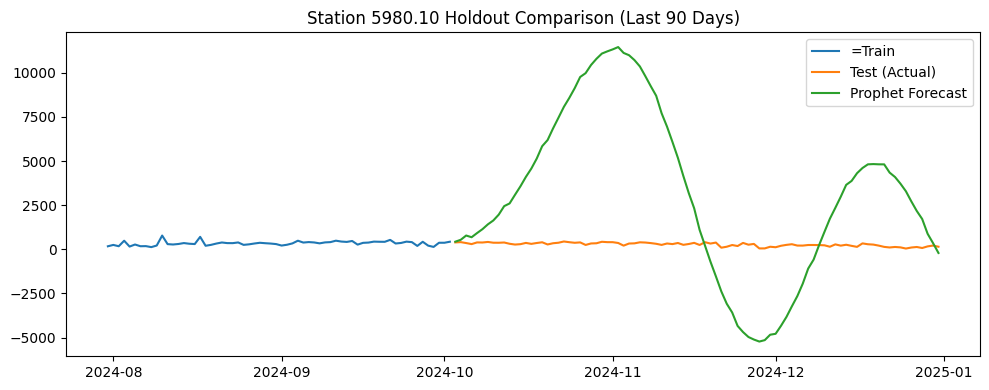

In [25]:
# Diagnostic plot for the worst Prophet station

worst_station = pd.DataFrame(station_prophet_results).sort_values("rmse", ascending=False).iloc[0]["station_id"]
ts = get_daily_series(dfs, STATION_ID_COL, worst_station, DATE_COL, STATION_TARGET_COL)
train, test = train_test_split_series(ts, test_days=90)

train_df = train.reset_index().rename(columns={DATE_COL: "ds", STATION_TARGET_COL: "y"})
test_df = test.reset_index().rename(columns={DATE_COL: "ds", STATION_TARGET_COL: "y"})

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode="additive")
m.fit(train_df)
fcst = m.predict(pd.DataFrame({"ds": test_df["ds"]}))

plt.figure(figsize=(10, 4))
plt.plot(train.index, train.values, label="=Train")
plt.plot(test.index, test.values, label="Test (Actual)")
plt.plot(test.index, fcst["yhat"].values, label="Prophet Forecast")
plt.title(f"Station {worst_station} Holdout Comparison (Last 90 Days)")
plt.legend()
plt.tight_layout()
plt.show()

## Evaluation design for baselines

* Time-ordered splits (no shuffling):

  * Models were trained on 2017–2021, validated on 2022, and tested on 2023–2024.

* Evaluation metrics:

  * For each model, RMSE, MAE, and MAPE were computed at a one-day-ahead forecast horizon and summarized across evaluation periods.

Deliverables:

* A consolidated performance table comparing ARIMA, ETS, and Prophet models.
* Decomposition plots (trend and seasonal components) illustrating temporal structure and calendar- and weather-related effects.

In [26]:
BASE_DIR = "/Users/zoltanjelovich/Documents/ISEG/MFW/data"

Y_PATH = f"{BASE_DIR}/targets/system/y_daily_system.parquet"
X_PATH = f"{BASE_DIR}/features/system/X_daily_system.parquet"

DATE_COL = "date"
TARGET_COL = "trips"

EXOG_COLS = [
    "temp_avg_f",
    "precip_inches",
    "is_holiday",
    "is_weekend",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

In [27]:
# Load + validate + merge

y_sys = pd.read_parquet(Y_PATH)
X_sys = pd.read_parquet(X_PATH)

required_y = {DATE_COL, TARGET_COL}
required_x = {DATE_COL, *EXOG_COLS}

if not required_y.issubset(y_sys.columns):
    raise KeyError(f"Missing columns in y_daily_system: {required_y - set(y_sys.columns)}")

if not required_x.issubset(X_sys.columns):
    raise KeyError(f"Missing columns in X_daily_system: {required_x - set(X_sys.columns)}")

# Keep only what is needed, se-dup dates
y_sys = y_sys[[DATE_COL, TARGET_COL]].drop_duplicates(subset=[DATE_COL]).copy()
X_sys = X_sys[[DATE_COL, *EXOG_COLS]].drop_duplicates(subset=[DATE_COL]).copy()

df = (
    y_sys.merge(X_sys, on=DATE_COL, how="inner")
         .sort_values(DATE_COL)
         .reset_index(drop=True)
)

# Enforce daily frequency
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.set_index(DATE_COL).asfreq("D")

# Check for missing dates and missingness in exog after alignment
missing_dates = int(df.index.isna().sum())
print("Date range:", df.index.min(), "→", df.index.max(), "n=", len(df))
print("Missing dates introduced by asfreq:", df[TARGET_COL].isna().sum())

# Interpolate gaps + forward/back fill edges
df[TARGET_COL] = df[TARGET_COL].interpolate(limit=7).ffill().bfill()
for c in EXOG_COLS:
    df[c] = df[c].interpolate(limit=7).ffill().bfill()

# Final sanity check
if df[[TARGET_COL, *EXOG_COLS]].isna().any().any():
    bad = df[[TARGET_COL, *EXOG_COLS]].isna().sum()
    raise ValueError(f"NaNs remain after interpolation/fill:\n{bad}")

df.head()

Date range: 2017-01-01 00:00:00 → 2024-12-31 00:00:00 n= 2922
Missing dates introduced by asfreq: 0


,trips,temp_avg_f,precip_inches,is_holiday,is_weekend,regime_pre_covid,regime_covid,regime_recovery
date,,,,,,,,
2017-01-01,15993,45.0,0.000,False,True,0,0,0
2017-01-02,8916,39.4,0.216,True,False,0,0,0
2017-01-03,14196,41.6,0.501,False,False,0,0,0
2017-01-04,34033,45.1,0.000,False,False,0,0,0
2017-01-05,28388,32.4,0.000,False,False,0,0,0


In [28]:
# Time-ordered splits

train = df.loc["2017-01-01":"2021-12-31"].copy()
val   = df.loc["2022-01-01":"2022-12-31"].copy()
test  = df.loc["2023-01-01":"2024-12-31"].copy()

print("Train:", train.index.min(), "→", train.index.max(), "n=", len(train))
print("Val:  ", val.index.min(),   "→", val.index.max(),   "n=", len(val))
print("Test: ", test.index.min(),  "→", test.index.max(),  "n=", len(test))

Train: 2017-01-01 00:00:00 → 2021-12-31 00:00:00 n= 1826
Val:   2022-01-01 00:00:00 → 2022-12-31 00:00:00 n= 365
Test:  2023-01-01 00:00:00 → 2024-12-31 00:00:00 n= 731


In [29]:
# Metrics helpers

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def mape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def summarize_metrics(name, y_true, y_pred, split_name):
    return {
        "model": name,
        "split": split_name,
        "RMSE": rmse(y_true, y_pred),
        "MAE": mae(y_true, y_pred),
        "MAPE_%": mape(y_true, y_pred),
        "n": len(y_true),
    }

In [30]:
# Enforce numeric dtypes

BINARY_EXOG = [
    "is_holiday",
    "is_weekend",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]
CONT_EXOG = ["temp_avg_f", "precip_inches"]

# Force target numeric
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="raise").astype(float)

# Force continuous exog numeric float
for c in CONT_EXOG:
    df[c] = pd.to_numeric(df[c], errors="raise").astype(float)

# Force binary exog numeric int
for c in BINARY_EXOG:
    df[c] = pd.to_numeric(df[c], errors="raise").astype(int)

# Final NA check
na_counts = df[[TARGET_COL] + EXOG_COLS].isna().sum()
if (na_counts > 0).any():
    raise ValueError(f"NaNs remain after dtype enforcement:\n{na_counts[na_counts>0]}")

# Print dtypes for confirmation
df[[TARGET_COL] + EXOG_COLS].dtypes

trips               float64
temp_avg_f          float64
precip_inches       float64
is_holiday            int64
is_weekend            int64
regime_pre_covid      int64
regime_covid          int64
regime_recovery       int64
dtype: object

In [31]:
# Rolling 1-day-ahead evaluation (SARIMAX)

SARIMAX_ORDER = (1, 0, 1)
SARIMAX_SEASONAL = (0, 1, 1, 7)

def rolling_one_step_sarimax(train_df, eval_df):
    y_train = train_df[TARGET_COL].astype(float).to_numpy()
    X_train = train_df[EXOG_COLS].astype(float).to_numpy()

    mod = SARIMAX(
        y_train,
        exog=X_train,
        order=SARIMAX_ORDER,
        seasonal_order=SARIMAX_SEASONAL,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = mod.fit(disp=False)

    preds = []
    actuals = []

    for dt, row in eval_df.iterrows():
        x_next = row[EXOG_COLS].astype(float).to_numpy().reshape(1, -1)
        y_true = float(row[TARGET_COL])

        fc = float(res.get_forecast(steps=1, exog=x_next).predicted_mean[0])

        preds.append(fc)
        actuals.append(y_true)

        # Update state with the realized observation
        res = res.append(endog=[y_true], exog=x_next, refit=False)

    return np.array(actuals), np.array(preds), res

y_val_true_sx, y_val_pred_sx, sarimax_res_end = rolling_one_step_sarimax(train, val)
y_test_true_sx, y_test_pred_sx, _ = rolling_one_step_sarimax(pd.concat([train, val]), test)

print("SARIMAX done.")

SARIMAX done.


In [32]:
# Rolling 1-day-ahead evaluation (ETS)

def rolling_one_step_ets(train_df, eval_df):
    hist = train_df[TARGET_COL].astype(float).copy()

    preds = []
    actuals = []

    for dt, row in eval_df.iterrows():
        # Fit ETS on history up to t-1
        mod = ETSModel(
            hist,
            error="add",
            trend=None,
            seasonal="add",
            seasonal_periods=7,
        )
        res = mod.fit(disp=False)

        # 1-step ahead forecast for t
        fc = float(res.forecast(steps=1).iloc[0])
        y_true = float(row[TARGET_COL])

        preds.append(fc)
        actuals.append(y_true)

        # Expand history with realized y(t)
        hist = pd.concat([hist, pd.Series([y_true], index=[dt])])

    return np.array(actuals), np.array(preds)

y_val_true_ets, y_val_pred_ets = rolling_one_step_ets(train, val)
y_test_true_ets, y_test_pred_ets = rolling_one_step_ets(pd.concat([train, val]), test)

print("ETS done.")

ETS done.


In [33]:
# ETS(A,N,A), s=7 + exog  (implemented as: OLS(xreg) + ETS on residuals)

WEATHER_COLS = ["temp_avg_f", "precip_inches"]

def rolling_one_step_ets_exog(train_df, eval_df, exog_cols, seasonal_periods=7):
    # History
    hist_y = train_df[TARGET_COL].astype(float).copy()
    hist_X = train_df[exog_cols].astype(float).copy()

    preds, actuals = [], []

    for dt, row in eval_df.iterrows():
        y_true = float(row[TARGET_COL])
        x_next = row[exog_cols].astype(float).to_numpy()

        # Regression part (OLS with intercept)
        X_ols = sm.add_constant(hist_X.to_numpy(), has_constant="add")
        ols = sm.OLS(hist_y.to_numpy(), X_ols).fit()

        y_hat_hist = ols.predict(X_ols)
        resid = pd.Series(hist_y.to_numpy() - y_hat_hist, index=hist_y.index)

        x_next_const = np.r_[1.0, x_next]
        fc_reg = float(np.dot(x_next_const, ols.params))

        # ETS on residuals part
        ets_mod = ETSModel(
            resid,
            error="add",
            trend=None,
            seasonal="add",
            seasonal_periods=seasonal_periods,
        )
        ets_res = ets_mod.fit(disp=False)
        fc_resid = float(ets_res.forecast(1).iloc[0])

        # Combined forecast
        fc = fc_reg + fc_resid

        preds.append(fc)
        actuals.append(y_true)

        # Update history with realized y and known exog at dt
        hist_y = pd.concat([hist_y, pd.Series([y_true], index=[dt])])
        hist_X = pd.concat([hist_X, pd.DataFrame([x_next], index=[dt], columns=exog_cols)])

    return np.array(actuals), np.array(preds)

# ETS(A,N,A), s=7 + exog (all EXOG_COLS)
y_val_true_etsx, y_val_pred_etsx = rolling_one_step_ets_exog(train, val, EXOG_COLS, seasonal_periods=7)
y_test_true_etsx, y_test_pred_etsx = rolling_one_step_ets_exog(pd.concat([train, val]), test, EXOG_COLS, seasonal_periods=7)

print("ETS + exog done.")

# ETS(A,N,A), s=7 + exog (minus weather)
EXOG_COLS_NO_WEATHER = [c for c in EXOG_COLS if c not in WEATHER_COLS]

y_val_true_etsx_nowx, y_val_pred_etsx_nowx = rolling_one_step_ets_exog(train, val, EXOG_COLS_NO_WEATHER, seasonal_periods=7)
y_test_true_etsx_nowx, y_test_pred_etsx_nowx = rolling_one_step_ets_exog(pd.concat([train, val]), test, EXOG_COLS_NO_WEATHER, seasonal_periods=7)

print("ETS + exog (minus weather) done.")

ETS + exog done.
ETS + exog (minus weather) done.


In [34]:
# Performance table (SARIMAX + ETS) for Val and Test

rows = []
rows.append(summarize_metrics("SARIMAX(1,0,1)x(0,1,1,7)+exog", y_val_true_sx, y_val_pred_sx, "validation_2022"))
rows.append(summarize_metrics("SARIMAX(1,0,1)x(0,1,1,7)+exog", y_test_true_sx, y_test_pred_sx, "test_2023_2024"))

rows.append(summarize_metrics("ETS(A,N,A), s=7", y_val_true_ets, y_val_pred_ets, "validation_2022"))
rows.append(summarize_metrics("ETS(A,N,A), s=7", y_test_true_ets, y_test_pred_ets, "test_2023_2024"))

rows.append(summarize_metrics("ETS(A,N,A), s=7 + exog", y_val_true_etsx, y_val_pred_etsx, "validation_2022"))
rows.append(summarize_metrics("ETS(A,N,A), s=7 + exog", y_test_true_etsx, y_test_pred_etsx, "test_2023_2024"))

rows.append(summarize_metrics("ETS(A,N,A), s=7 + exog (minus weather)", y_val_true_etsx_nowx, y_val_pred_etsx_nowx, "validation_2022"))
rows.append(summarize_metrics("ETS(A,N,A), s=7 + exog (minus weather)", y_test_true_etsx_nowx, y_test_pred_etsx_nowx, "test_2023_2024"))

perf_table_all = (
    pd.DataFrame(rows)
      .sort_values(["split", "RMSE"])
      .reset_index(drop=True)
)
perf_table_all

,model,split,RMSE,MAE,MAPE_%,n
0,"ETS(A,N,A), s=7 + exog",test_2023_2024,15180.849626,10894.677585,14.004030,731
1,"SARIMAX(1,0,1)x(0,1,1,7)+exog",test_2023_2024,15476.483241,11095.092090,14.216350,731
2,"ETS(A,N,A), s=7 + exog (minus weather)",test_2023_2024,20484.246555,14733.208023,19.789009,731
3,"ETS(A,N,A), s=7",test_2023_2024,20597.695130,14622.716283,19.768977,731
4,"ETS(A,N,A), s=7 + exog",validation_2022,12170.947066,9182.932023,16.798468,365
5,"SARIMAX(1,0,1)x(0,1,1,7)+exog",validation_2022,12235.037202,8963.767099,16.671088,365
6,"ETS(A,N,A), s=7",validation_2022,16312.540403,12288.425978,24.887635,365
7,"ETS(A,N,A), s=7 + exog (minus weather)",validation_2022,16363.410035,12454.265960,25.184641,365


In [35]:
PROPHET_KWARGS = dict(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
)

In [36]:
def rolling_one_step_prophet(train_df: pd.DataFrame, eval_df: pd.DataFrame, use_regressors: bool):
    # Build initial history dataframe
    hist = train_df.copy()
    hist = hist.sort_index()

    preds = []
    actuals = []

    for dt, row in eval_df.sort_index().iterrows():
        # Prepare training df for Prophet
        fit_df = hist.reset_index().rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
        if use_regressors:
            for c in EXOG_COLS:
                fit_df[c] = fit_df[c].astype(float)

        # Fit Prophet
        m = Prophet(**PROPHET_KWARGS)
        if use_regressors:
            for c in EXOG_COLS:
                m.add_regressor(c)

        m.fit(fit_df)

        # Prepare one-row future df for day dt
        future = pd.DataFrame({"ds": [dt]})
        if use_regressors:
            for c in EXOG_COLS:
                future[c] = float(row[c])

        fcst = m.predict(future)
        yhat = float(fcst["yhat"].iloc[0])
        ytrue = float(row[TARGET_COL])

        preds.append(yhat)
        actuals.append(ytrue)

        # Expand history with realized y(t)
        hist.loc[dt, TARGET_COL] = ytrue
        if use_regressors:
            for c in EXOG_COLS:
                hist.loc[dt, c] = float(row[c])

    return np.array(actuals), np.array(preds)

# Baseline Prophet (no regressors)
y_val_true_p, y_val_pred_p = rolling_one_step_prophet(train, val, use_regressors=False)
y_test_true_p, y_test_pred_p = rolling_one_step_prophet(pd.concat([train, val]), test, use_regressors=False)

print("Prophet baseline done.")

# Prophet + regressors
y_val_true_px, y_val_pred_px = rolling_one_step_prophet(train, val, use_regressors=True)
y_test_true_px, y_test_pred_px = rolling_one_step_prophet(pd.concat([train, val]), test, use_regressors=True)

print("Prophet + regressors done.")

Prophet baseline done.
Prophet + regressors done.


In [37]:
rows = []

# Existing models
rows.append(summarize_metrics("SARIMAX(1,0,1)x(0,1,1,7)+exog", y_val_true_sx, y_val_pred_sx, "validation_2022"))
rows.append(summarize_metrics("SARIMAX(1,0,1)x(0,1,1,7)+exog", y_test_true_sx, y_test_pred_sx, "test_2023_2024"))

rows.append(summarize_metrics("ETS(A,N,A), s=7 + exog", y_val_true_etsx, y_val_pred_etsx, "validation_2022"))
rows.append(summarize_metrics("ETS(A,N,A), s=7 + exog", y_test_true_etsx, y_test_pred_etsx, "test_2023_2024"))

# New Prophet rows
rows.append(summarize_metrics("Prophet (weekly+yearly)", y_val_true_p, y_val_pred_p, "validation_2022"))
rows.append(summarize_metrics("Prophet (weekly+yearly)", y_test_true_p, y_test_pred_p, "test_2023_2024"))

rows.append(summarize_metrics("Prophet + exog", y_val_true_px, y_val_pred_px, "validation_2022"))
rows.append(summarize_metrics("Prophet + exog", y_test_true_px, y_test_pred_px, "test_2023_2024"))

perf_table_all = pd.DataFrame(rows).sort_values(["split", "RMSE"]).reset_index(drop=True)
perf_table_all

,model,split,RMSE,MAE,MAPE_%,n
0,"ETS(A,N,A), s=7 + exog",test_2023_2024,15180.849626,10894.677585,14.004030,731
1,"SARIMAX(1,0,1)x(0,1,1,7)+exog",test_2023_2024,15476.483241,11095.092090,14.216350,731
2,Prophet + exog,test_2023_2024,19600.568156,15270.896146,18.538565,731
3,Prophet (weekly+yearly),test_2023_2024,24122.516793,18742.141008,24.439592,731
4,"ETS(A,N,A), s=7 + exog",validation_2022,12170.947066,9182.932023,16.798468,365
5,"SARIMAX(1,0,1)x(0,1,1,7)+exog",validation_2022,12235.037202,8963.767099,16.671088,365
6,Prophet + exog,validation_2022,15087.092703,12085.740653,26.525551,365
7,Prophet (weekly+yearly),validation_2022,19770.207282,15614.625265,38.389887,365


In [38]:
# Fit final ETS(A,N,A) for interpretation (train+val)

SARIMAX_ORDER = (1, 0, 1)
SARIMAX_SEASONAL = (0, 1, 1, 7)

def assert_ready(df, name):
    if TARGET_COL not in df.columns:
        raise KeyError(f"{name} missing TARGET_COL='{TARGET_COL}'. Columns: {list(df.columns)}")
    missing_x = [c for c in EXOG_COLS if c not in df.columns]
    if missing_x:
        raise KeyError(f"{name} missing EXOG_COLS: {missing_x}")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError(f"{name} index must be DatetimeIndex.")
    if df.index.freq is None:
        pass

for _name, _df in [("train", train), ("val", val), ("test", test)]:
    assert_ready(_df, _name)

# Force numeric exog
def coerce_numeric_exog(df):
    out = df.copy()
    for c in EXOG_COLS:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

train = coerce_numeric_exog(train)
val = coerce_numeric_exog(val)
test = coerce_numeric_exog(test)

# Basic NA report
na_exog = train[EXOG_COLS].isna().sum().sum() + val[EXOG_COLS].isna().sum().sum() + test[EXOG_COLS].isna().sum().sum()
if na_exog > 0:
    print(f"WARNING: Found {na_exog} NA values in exogenous columns after numeric coercion.")
    print("Consider imputing (e.g., forward-fill) before fitting SARIMAX.")

In [39]:
train_val = pd.concat([train, val]).sort_index()

y_tv = train_val[TARGET_COL].astype(float)

ets_mod = ETSModel(
    y_tv,
    error="add",
    trend=None,
    seasonal="add",
    seasonal_periods=7,
)
ets_res = ets_mod.fit(disp=False)

print(ets_res.summary())

                                 ETS Results                                  
Dep. Variable:                  trips   No. Observations:                 2191
Model:                       ETS(ANA)   Log Likelihood              -23967.111
Date:                Thu, 29 Jan 2026   AIC                          47956.221
Time:                        12:03:09   BIC                          48018.835
Sample:                    01-01-2017   HQIC                         47979.106
                         - 12-31-2022   Scale                    185748722.869
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2623      0.020     13.088      0.000       0.223       0.302
smoothing_seasonal     0.0456      0.008      5.712      0.000       0.030       0.061
initial_level       

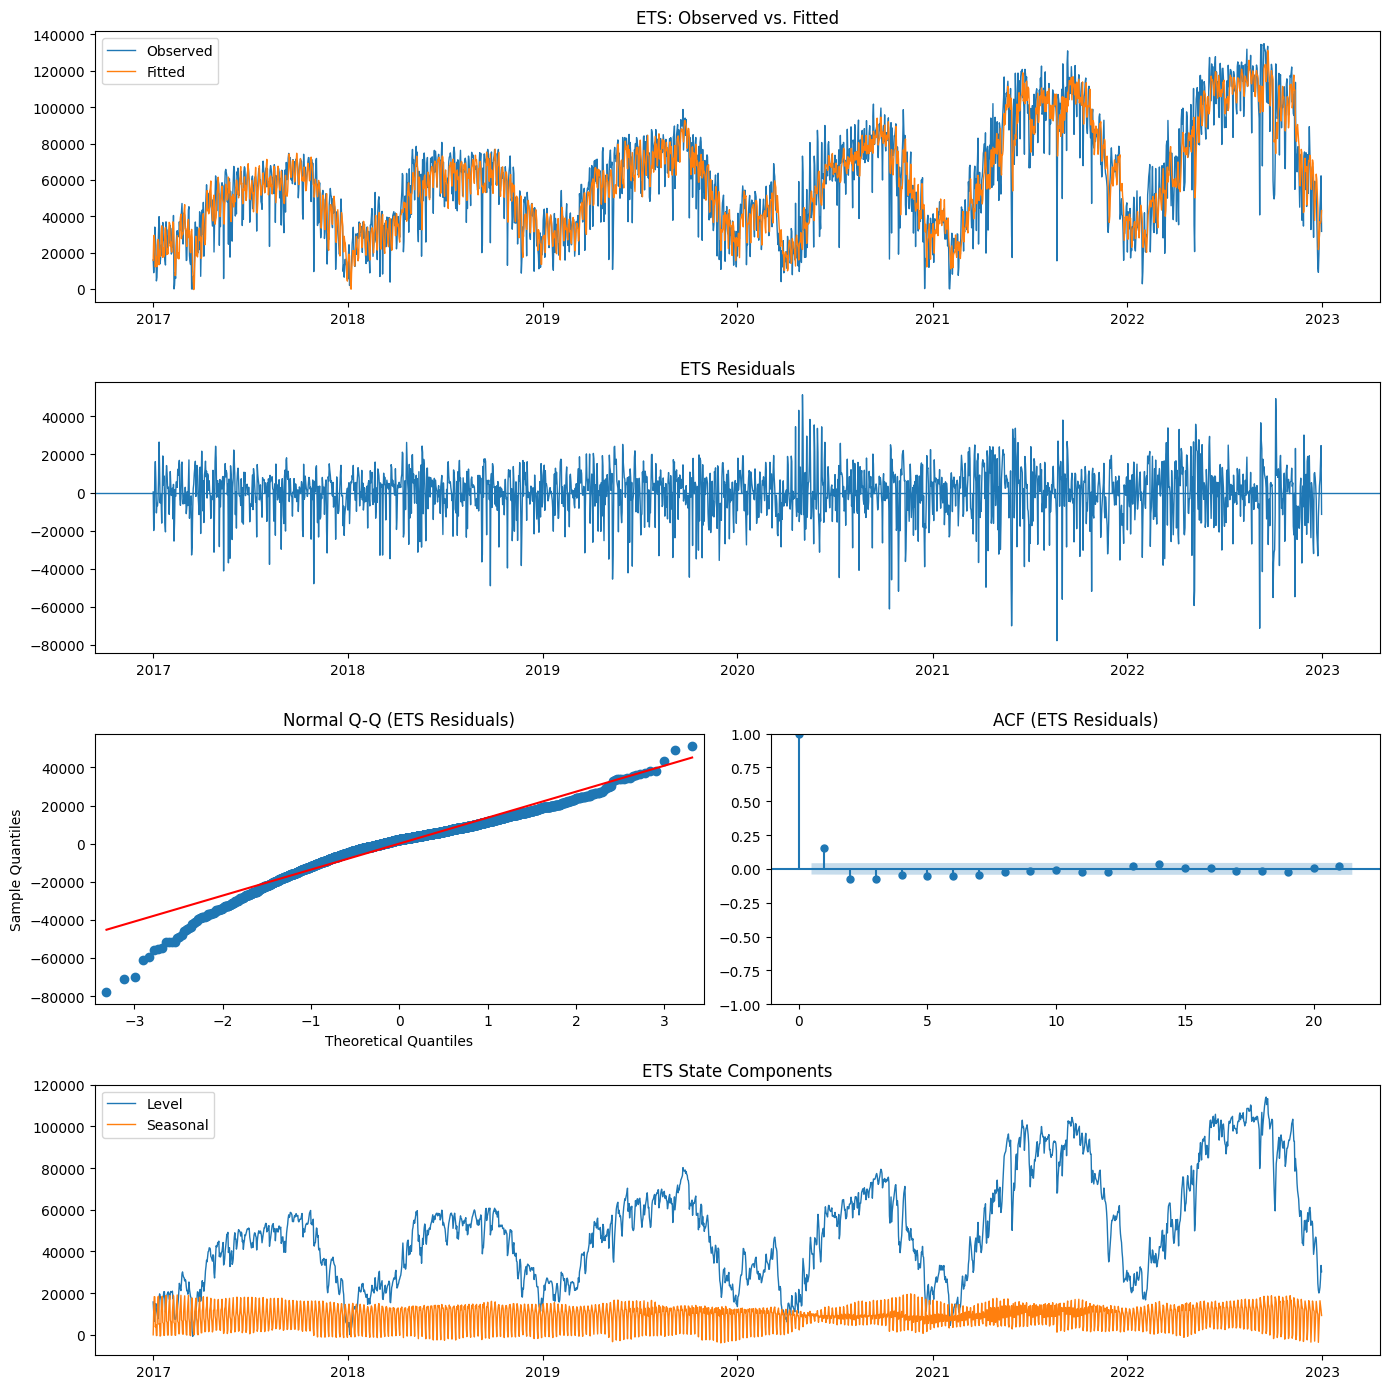

In [40]:
# ETS components plot

def plot_ets_diagnostics(ets_res, y, max_acf_lag=21):
    # Fitted + residuals
    fitted = pd.Series(ets_res.fittedvalues, index=y.index)
    resid = y - fitted

    # Try to pull state components if available
    level = None
    seasonal = None
    for attr in ["level", "l", "state_level"]:
        if hasattr(ets_res, attr):
            level = getattr(ets_res, attr)
            break
    for attr in ["season", "seasonal", "s", "state_seasonal"]:
        if hasattr(ets_res, attr):
            seasonal = getattr(ets_res, attr)
            break

    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(4, 2)

    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(y.index, y.values, label="Observed", linewidth=1)
    ax1.plot(fitted.index, fitted.values, label="Fitted", linewidth=1)
    ax1.set_title("ETS: Observed vs. Fitted")
    ax1.legend(loc="upper left")

    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(resid.index, resid.values, linewidth=1)
    ax2.axhline(0, linewidth=1)
    ax2.set_title("ETS Residuals")

    ax3 = fig.add_subplot(gs[2, 0])
    qqplot(resid.dropna().values, line="s", ax=ax3)
    ax3.set_title("Normal Q-Q (ETS Residuals)")

    ax4 = fig.add_subplot(gs[2, 1])
    plot_acf(resid.dropna().values, lags=max_acf_lag, ax=ax4)
    ax4.set_title("ACF (ETS Residuals)")

    ax5 = fig.add_subplot(gs[3, :])
    if level is not None:
        ax5.plot(y.index, np.asarray(level).reshape(-1), label="Level", linewidth=1)
    if seasonal is not None:
        s_arr = np.asarray(seasonal)
        # seasonal can be (nobs, s) or (nobs,)
        if s_arr.ndim == 2:
            # plot current seasonal position (diagonal-ish) isn't directly meaningful; summarize by last column
            ax5.plot(y.index, s_arr[:, -1], label="Seasonal (One State)", linewidth=1)
        else:
            ax5.plot(y.index, s_arr.reshape(-1), label="Seasonal", linewidth=1)
    if level is None and seasonal is None:
        ax5.text(0.01, 0.5, "Level/seasonal states not exposed in this statsmodels version.", transform=ax5.transAxes)
    ax5.set_title("ETS State Components")
    ax5.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

plot_ets_diagnostics(ets_res, y_tv, max_acf_lag=21)

In [41]:
X_tv = train_val[EXOG_COLS].astype(float)

sarimax_mod = SARIMAX(
    y_tv,
    exog=X_tv,
    order=SARIMAX_ORDER,
    seasonal_order=SARIMAX_SEASONAL,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarimax_res = sarimax_mod.fit(disp=False)

print(sarimax_res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             trips   No. Observations:                 2191
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -23227.942
Date:                           Thu, 29 Jan 2026   AIC                          46477.884
Time:                                   12:03:15   BIC                          46540.416
Sample:                               01-01-2017   HQIC                         46500.747
                                    - 12-31-2022                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp_avg_f         818.5736     57.525     14.230      0.000     705.827     931.320
precip_inches     -2.09e+

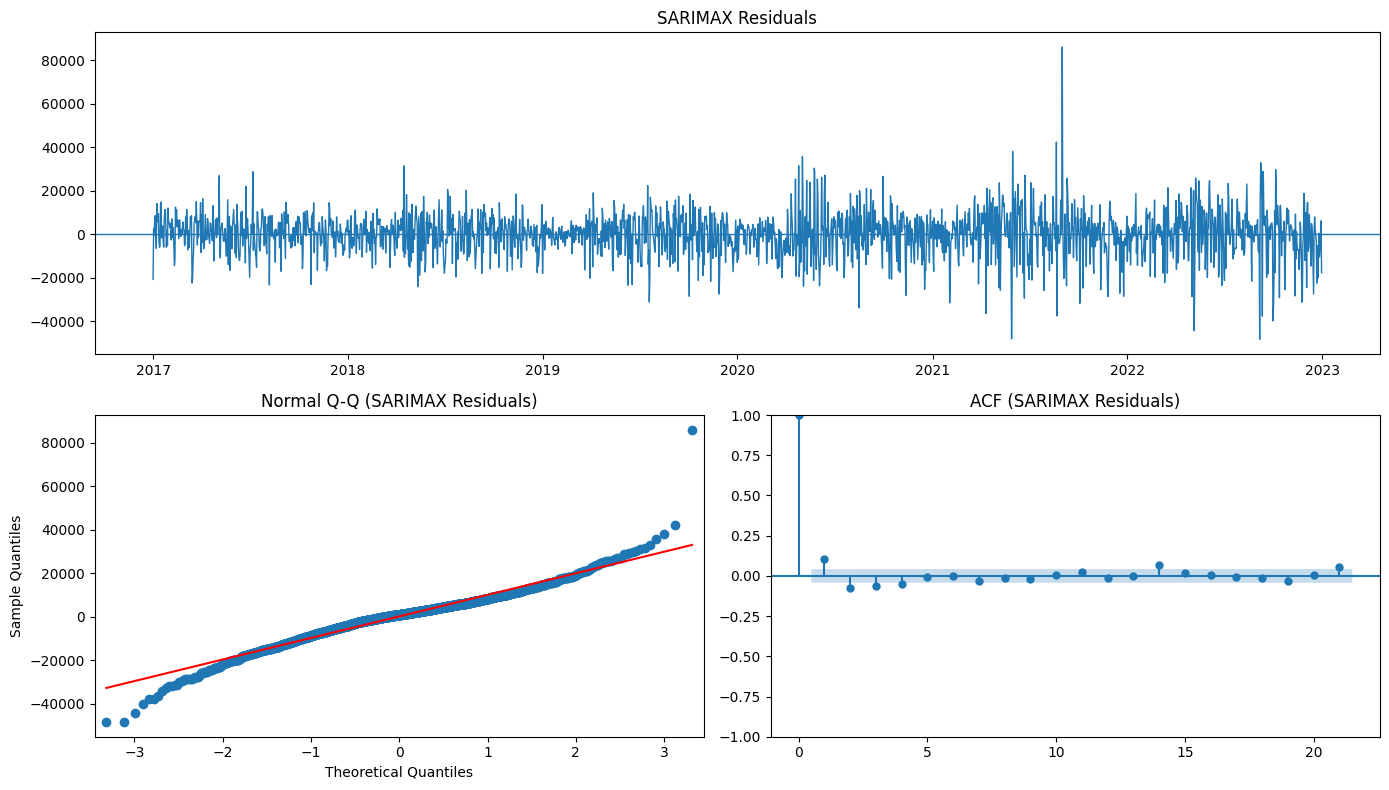

In [42]:
# SARIMAX residual diagnostics

def plot_sarimax_residual_diagnostics(res, max_acf_lag=21):
    resid = pd.Series(res.resid, index=res.data.row_labels).dropna()

    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(resid.index, resid.values, linewidth=1)
    ax1.axhline(0, linewidth=1)
    ax1.set_title("SARIMAX Residuals")

    ax2 = fig.add_subplot(gs[1, 0])
    qqplot(resid.values, line="s", ax=ax2)
    ax2.set_title("Normal Q-Q (SARIMAX Residuals)")

    ax3 = fig.add_subplot(gs[1, 1])
    plot_acf(resid.values, lags=max_acf_lag, ax=ax3)
    ax3.set_title("ACF (SARIMAX Residuals)")

    plt.tight_layout()
    plt.show()

plot_sarimax_residual_diagnostics(sarimax_res, max_acf_lag=21)

,param,coef,se,ci_low,ci_high
1,precip_inches,-20899.520423,275.288358,-21439.075690,-20359.965155
2,is_holiday,-11265.401196,1488.707550,-14183.214377,-8347.588015
3,is_weekend,-0.000001,11086.710621,-21729.553525,21729.553522
0,temp_avg_f,818.573589,57.524951,705.826756,931.320422
4,regime_pre_covid,7024.372677,9101.272209,-10813.793066,24862.538419
5,regime_covid,17499.577126,14408.168882,-10739.914966,45739.069218
6,regime_recovery,21563.324323,18714.414245,-15116.253588,58242.902234


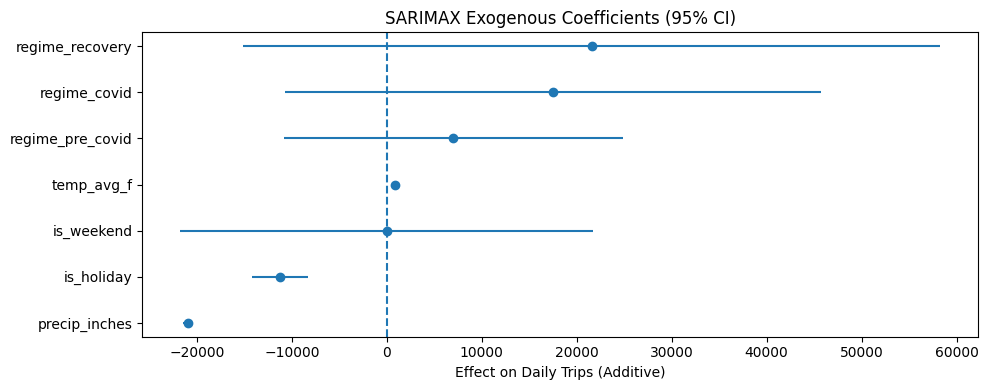

In [43]:
def sarimax_exog_coef_table(res, exog_cols):
    params = res.params.copy()
    ci = res.conf_int()
    se = res.bse.copy()

    exog_names = getattr(res.model, "exog_names", None)

    rows = []
    if exog_names is not None:
        for name in exog_names:
            if name in exog_cols:
                rows.append(name)

    if not rows:
        xnames = [n for n in params.index if n.startswith("x")]
        if xnames and len(xnames) == len(exog_cols):
            mapping = dict(zip(xnames, exog_cols))
            df = pd.DataFrame({
                "param": [mapping[x] for x in xnames],
                "coef": [params[x] for x in xnames],
                "se": [se[x] for x in xnames],
                "ci_low": [ci.loc[x, 0] for x in xnames],
                "ci_high": [ci.loc[x, 1] for x in xnames],
            })
            return df.sort_values("coef")
        else:
            inter = [c for c in exog_cols if c in params.index]
            df = pd.DataFrame({
                "param": inter,
                "coef": [params[c] for c in inter],
                "se": [se[c] for c in inter],
                "ci_low": [ci.loc[c, 0] for c in inter],
                "ci_high": [ci.loc[c, 1] for c in inter],
            })
            return df.sort_values("coef")

    df = pd.DataFrame({
        "param": rows,
        "coef": [params[r] for r in rows],
        "se": [se[r] for r in rows],
        "ci_low": [ci.loc[r, 0] for r in rows],
        "ci_high": [ci.loc[r, 1] for r in rows],
    })
    return df.sort_values("coef")

coef_df = sarimax_exog_coef_table(sarimax_res, EXOG_COLS)
display(coef_df)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(
    coef_df["coef"],
    coef_df["param"],
    xerr=[coef_df["coef"] - coef_df["ci_low"], coef_df["ci_high"] - coef_df["coef"]],
    fmt="o",
)
ax.axvline(0, linestyle="--")
ax.set_title("SARIMAX Exogenous Coefficients (95% CI)")
ax.set_xlabel("Effect on Daily Trips (Additive)")
plt.tight_layout()
plt.show()

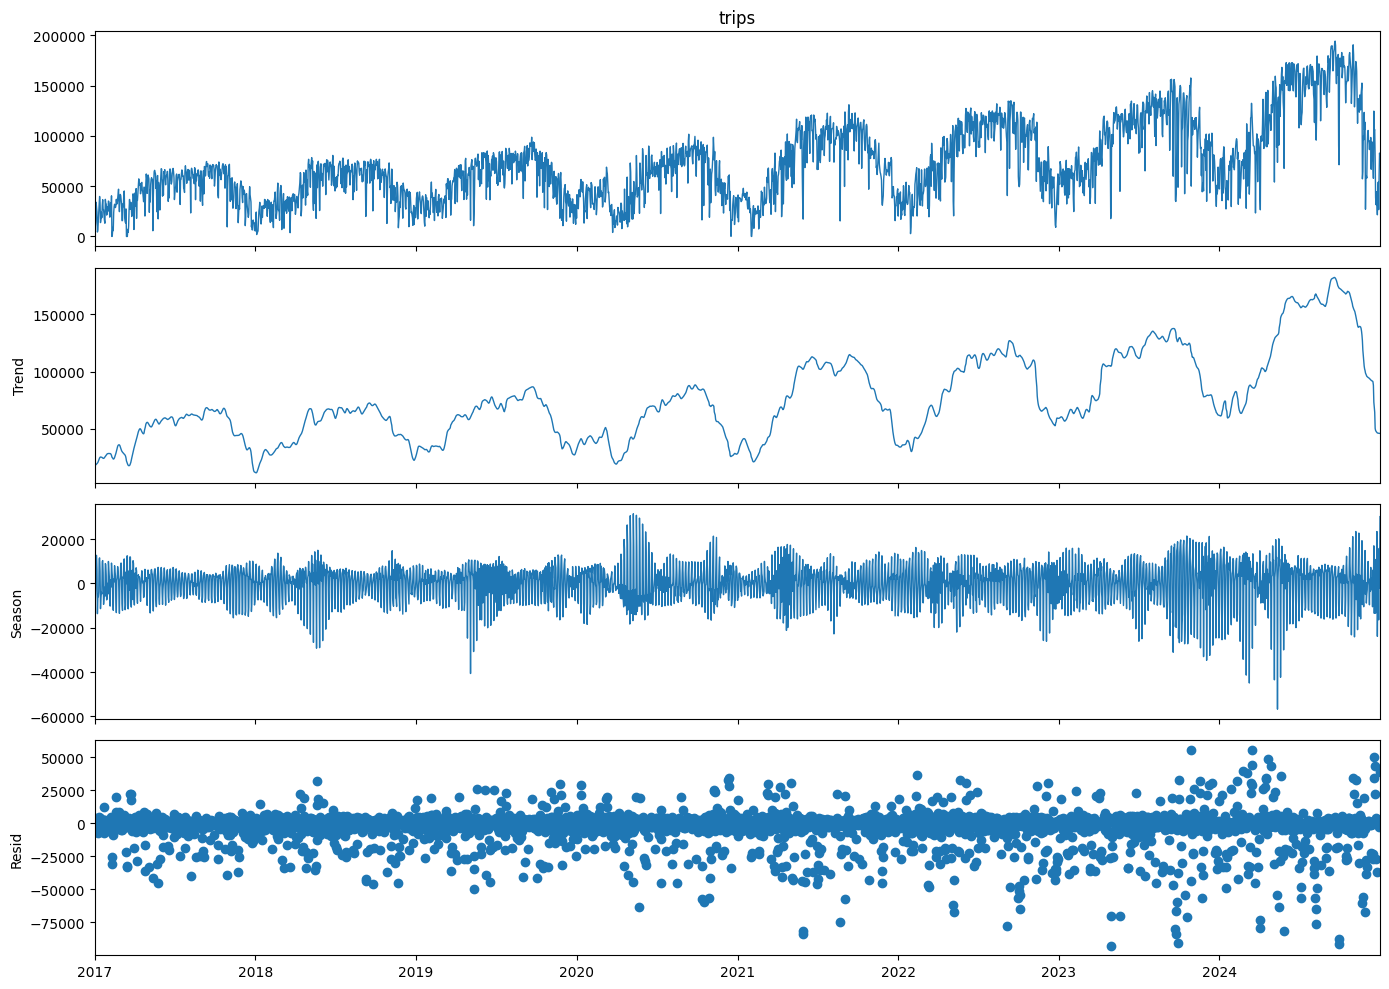

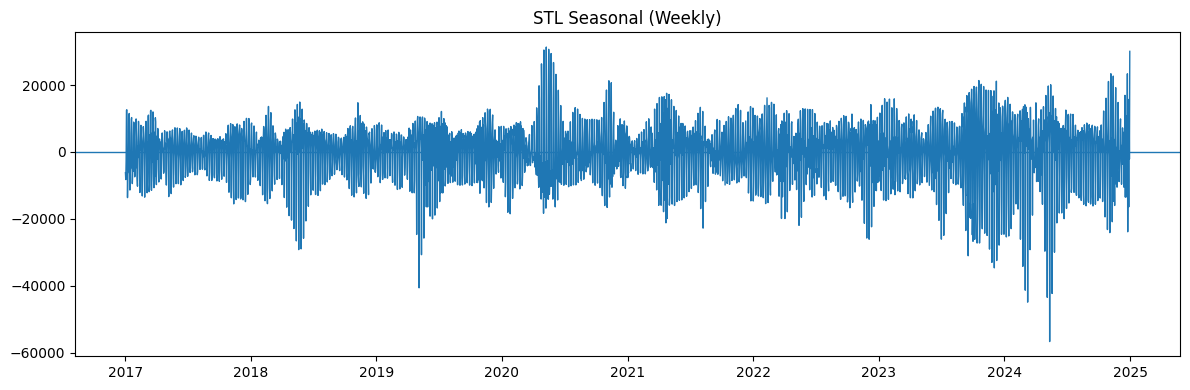

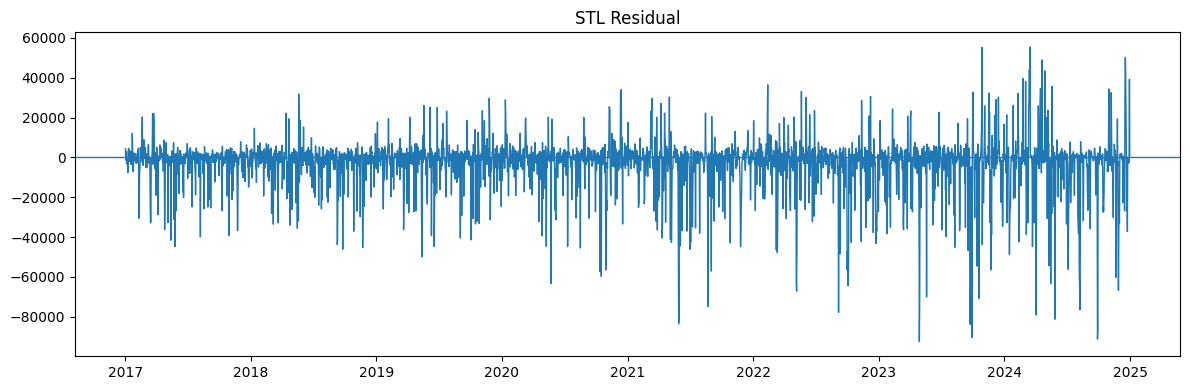

In [44]:
y_full = pd.concat([train, val, test]).sort_index()[TARGET_COL].astype(float)

stl = STL(y_full, period=7, robust=True)
stl_res = stl.fit()

fig = stl_res.plot()
fig.set_size_inches(14, 10)
for ax in fig.axes:
    for line in ax.lines:
        line.set_linewidth(1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(stl_res.seasonal.index, stl_res.seasonal.values, linewidth=1)
ax.axhline(0, linewidth=1)
ax.set_title("STL Seasonal (Weekly)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(stl_res.resid.index, stl_res.resid.values, linewidth=1)
ax.axhline(0, linewidth=1)
ax.set_title("STL Residual")
plt.tight_layout()
plt.show()

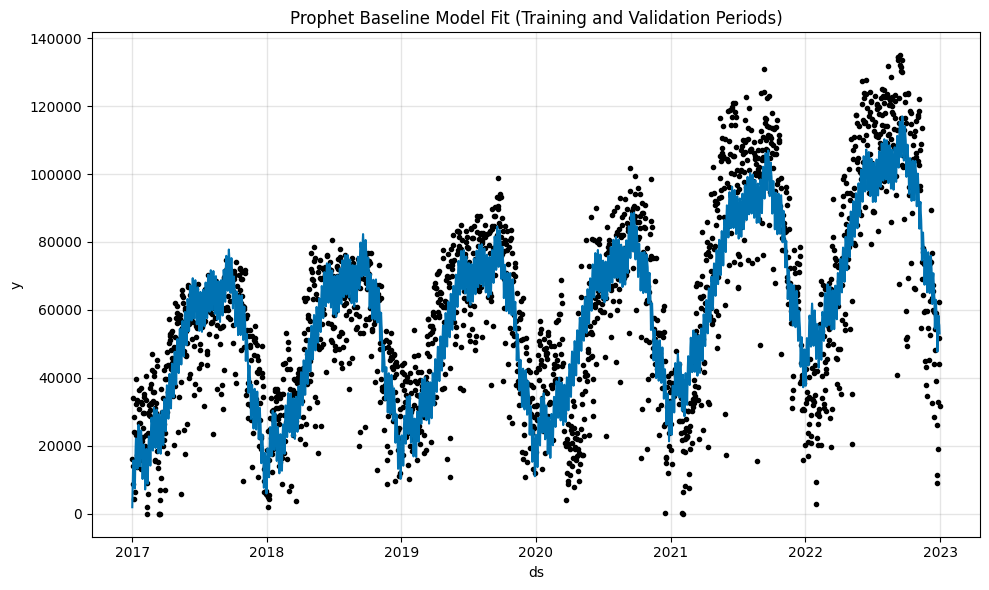

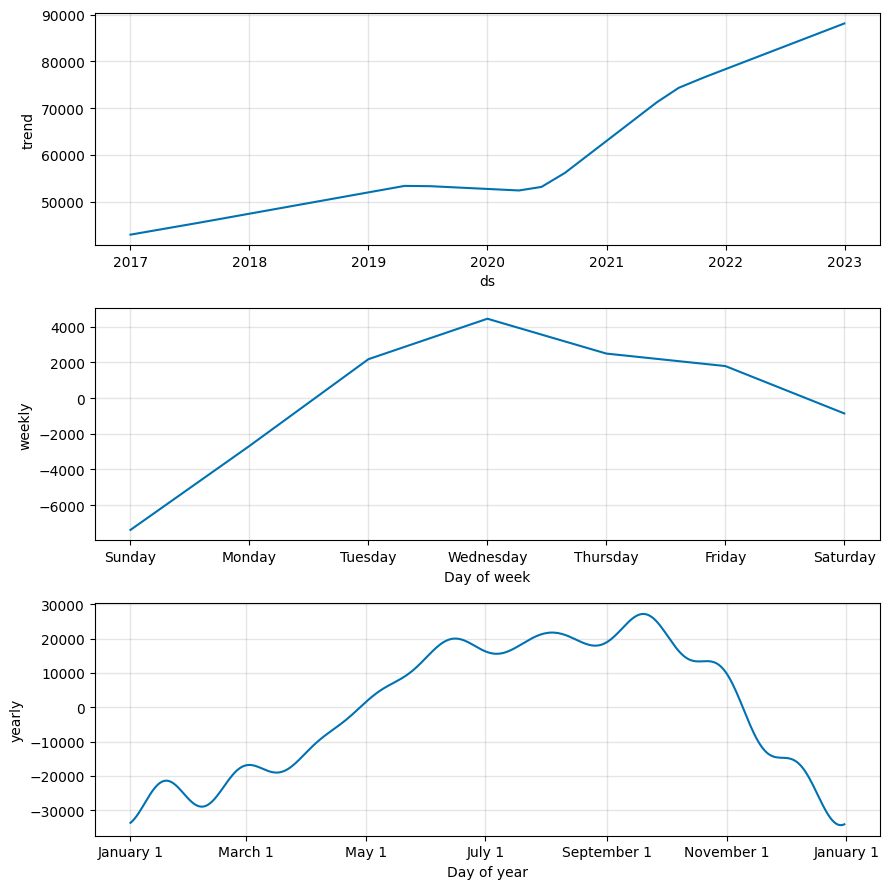

In [45]:
# Fit Prophet baseline (train+val) and plot components

trainval_df = pd.concat([train, val]).reset_index().rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
trainval_df = trainval_df.sort_values("ds")

m_base = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    uncertainty_samples=0,
)
m_base.fit(trainval_df)

fc_base = m_base.predict(trainval_df[["ds"]])

fig1 = m_base.plot(fc_base)
plt.title("Prophet Baseline Model Fit (Training and Validation Periods)")
plt.tight_layout()
plt.show()

fig2 = m_base.plot_components(fc_base)
plt.tight_layout()
plt.show()

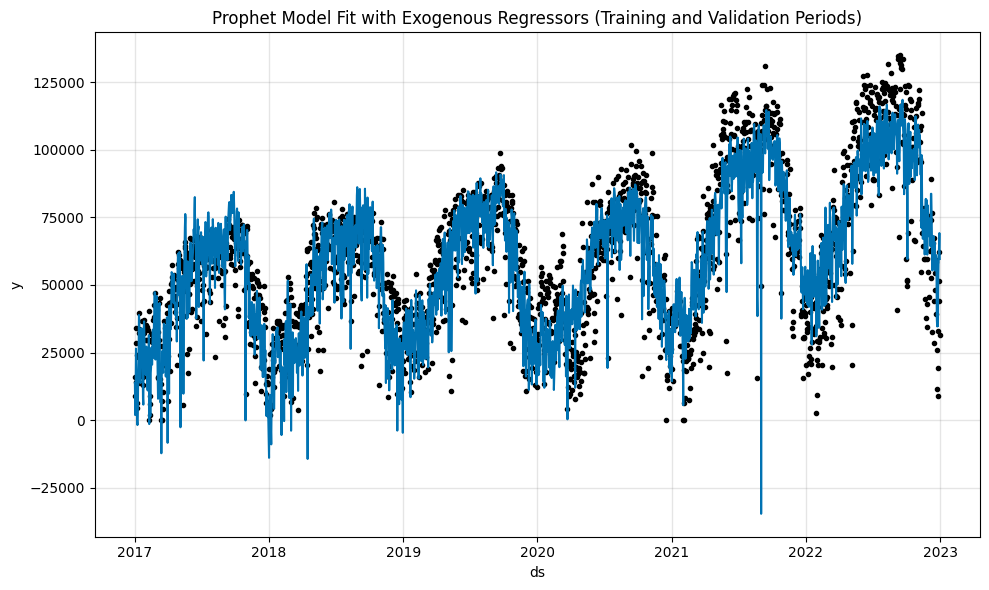

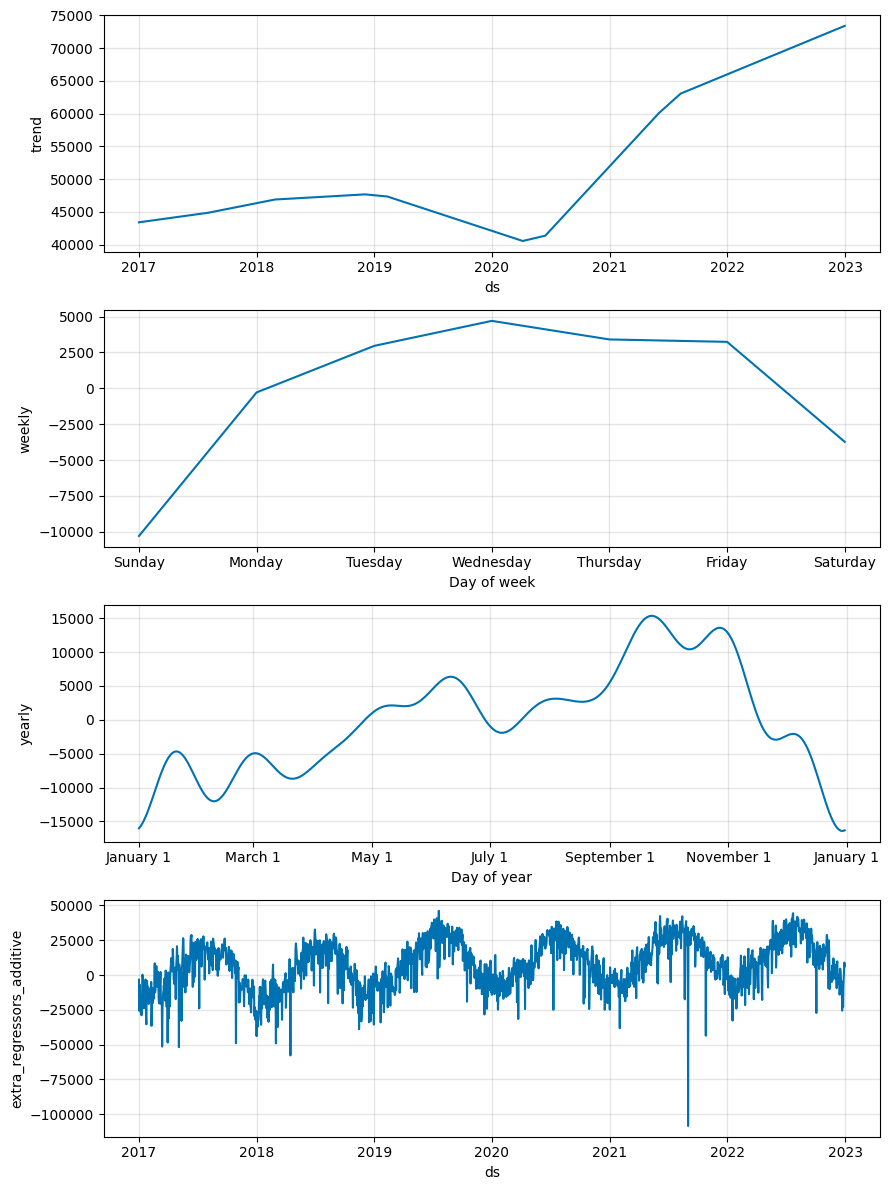

In [46]:
# Fit Prophet + exog and plot components

trainval_exog = pd.concat([train, val]).reset_index().rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
trainval_exog = trainval_exog.sort_values("ds")

m_exog = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    uncertainty_samples=0,
)

for c in EXOG_COLS:
    m_exog.add_regressor(c)

m_exog.fit(trainval_exog[["ds", "y"] + EXOG_COLS])

fc_exog = m_exog.predict(trainval_exog[["ds"] + EXOG_COLS])

fig1 = m_exog.plot(fc_exog)
plt.title("Prophet Model Fit with Exogenous Regressors (Training and Validation Periods)")
plt.tight_layout()
plt.show()

fig2 = m_exog.plot_components(fc_exog)
plt.tight_layout()
plt.show()

In [47]:
# Prophet regressor effect size table

# Extract Prophet regressor betas (standardized)
beta = m_exog.params["beta"][0]
regressor_names = m_exog.extra_regressors.keys()
regressor_names = list(regressor_names)

coef_raw = pd.DataFrame({
    "regressor": regressor_names,
    "beta_raw": beta[:len(regressor_names)]
})

# Approximate effect in trips per unit
y_std = trainval_exog["y"].std()

effects = []
for r in regressor_names:
    x_std = trainval_exog[r].std()
    effects.append((y_std / x_std) if x_std != 0 else np.nan)

coef_raw["approx_trips_per_unit"] = coef_raw["beta_raw"] * effects
coef_raw.sort_values("approx_trips_per_unit")

,regressor,beta_raw,approx_trips_per_unit
2,is_holiday,-0.019337,-3347.362837
1,precip_inches,-0.038386,-3154.235104
3,is_weekend,-0.032317,-2053.426286
5,regime_covid,-0.007839,-603.194928
0,temp_avg_f,-0.051124,-86.566777
6,regime_recovery,0.002358,143.570298
4,regime_pre_covid,0.023252,1791.247577


In [48]:
# Target and exog
y_tv = train_val[TARGET_COL].astype(float)
X_tv = train_val[EXOG_COLS].astype(float)

# OLS on exogenous regressors
X_ols = sm.add_constant(X_tv, has_constant="add")
ols_res = sm.OLS(y_tv, X_ols).fit()

y_hat_reg = pd.Series(
    ols_res.predict(X_ols),
    index=y_tv.index
)

resid_tv = y_tv - y_hat_reg

# ETS on residuals
etsx_resid_mod = ETSModel(
    resid_tv,
    error="add",
    trend=None,
    seasonal="add",
    seasonal_periods=7,
)

etsx_resid_res = etsx_resid_mod.fit(disp=False)

print(etsx_resid_res.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                 2191
Model:                       ETS(ANA)   Log Likelihood              -23344.255
Date:                Thu, 29 Jan 2026   AIC                          46710.511
Time:                        12:03:21   BIC                          46773.124
Sample:                    01-01-2017   HQIC                         46733.395
                         - 12-31-2022   Scale                    105197210.196
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2467      0.020     12.110      0.000       0.207       0.287
smoothing_seasonal     0.0608      0.010      6.353      0.000       0.042       0.080
initial_level       

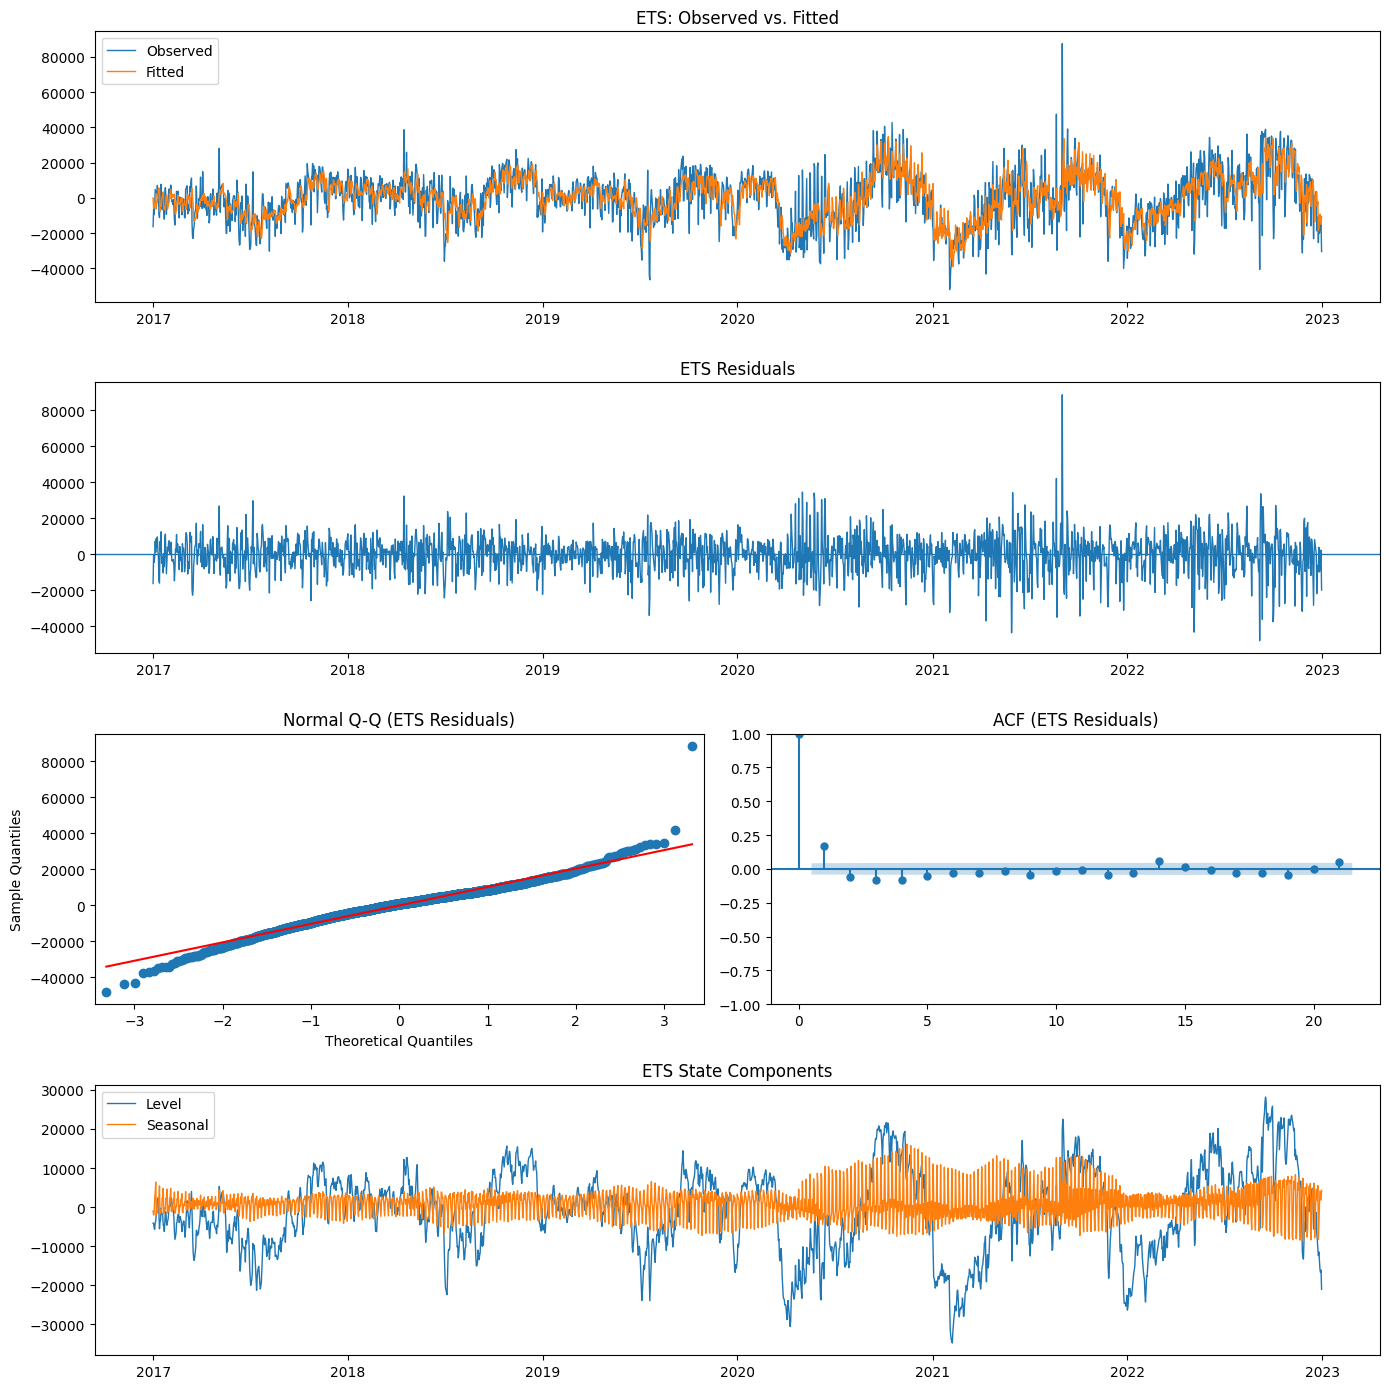

In [49]:
# Residual diagnostics for ETS + exog
plot_ets_diagnostics(
    etsx_resid_res,
    resid_tv,
    max_acf_lag=21
)

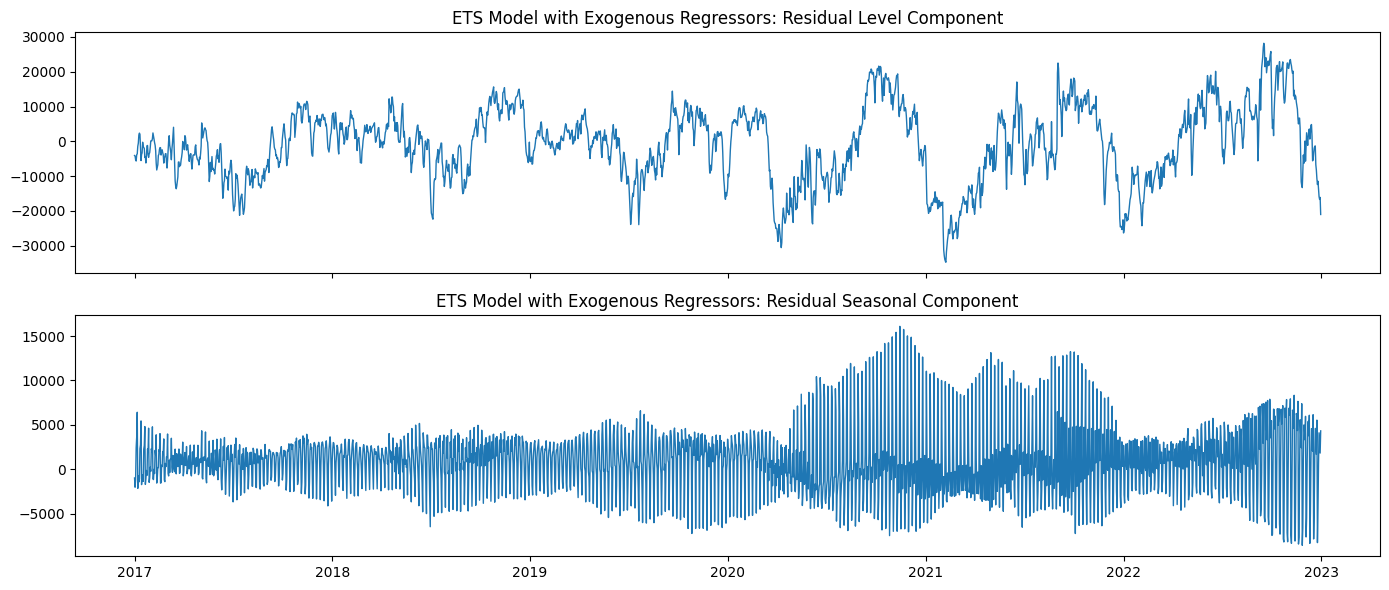

In [50]:
def extract_ets_states(ets_res, index):
    level, seasonal = None, None

    for attr in ["level", "l", "state_level"]:
        if hasattr(ets_res, attr):
            level = getattr(ets_res, attr)
            break

    for attr in ["season", "s", "seasonal", "state_seasonal"]:
        if hasattr(ets_res, attr):
            seasonal = getattr(ets_res, attr)
            break

    if level is not None:
        level = pd.Series(np.asarray(level).reshape(-1), index=index)

    if seasonal is not None:
        seasonal = pd.Series(
            np.asarray(seasonal).reshape(-1)[: len(index)],
            index=index
        )

    return level, seasonal


level_x, seasonal_x = extract_ets_states(etsx_resid_res, resid_tv.index)

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

if level_x is not None:
    ax[0].plot(level_x, linewidth=1)
    ax[0].set_title("ETS Model with Exogenous Regressors: Residual Level Component")
else:
    ax[0].text(0.01, 0.5, "Level state not available", transform=ax[0].transAxes)

if seasonal_x is not None:
    ax[1].plot(seasonal_x, linewidth=1)
    ax[1].set_title("ETS Model with Exogenous Regressors: Residual Seasonal Component")
else:
    ax[1].text(0.01, 0.5, "Seasonal state not available", transform=ax[1].transAxes)

plt.tight_layout()
plt.show()

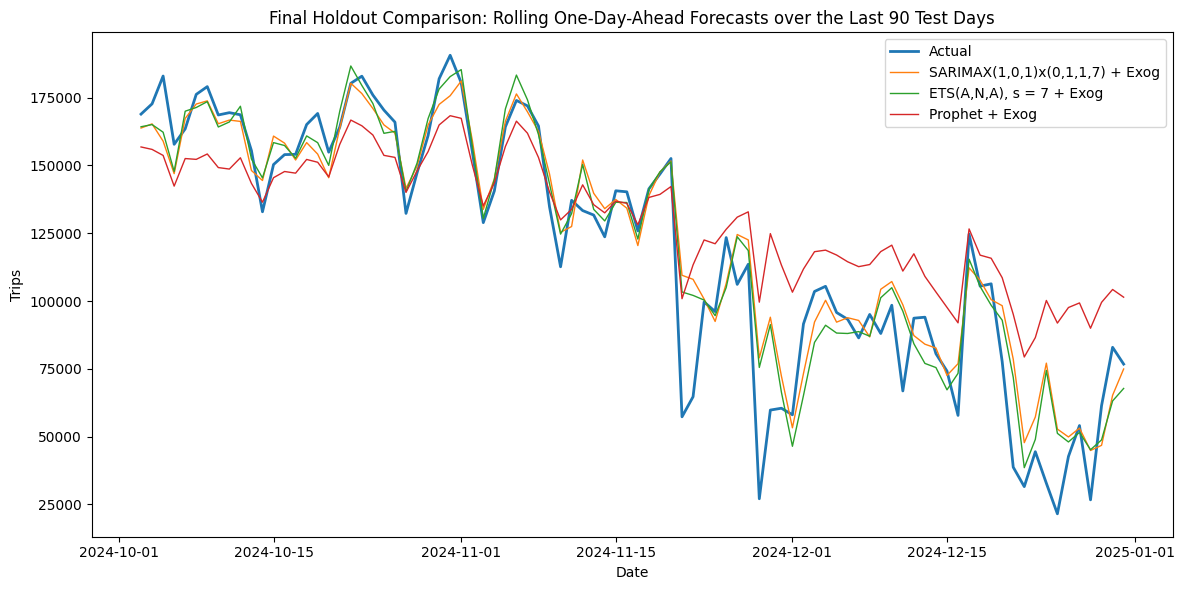

In [51]:
# 90-day holdout plot (rolling 1-day-ahead)

HOLDOUT_DAYS = 90

test_idx = test.index
if not isinstance(test_idx, pd.DatetimeIndex):
    test_idx = pd.to_datetime(test_idx)

holdout = test.iloc[-HOLDOUT_DAYS:].copy()
hist_df = pd.concat([train, val, test.iloc[:-HOLDOUT_DAYS]], axis=0)  # history up to holdout start

# Ensure exog exists and is numeric
X_cols = EXOG_COLS
hist_y = hist_df[TARGET_COL].astype(float)
hist_X = hist_df[X_cols].astype(float)

y_hold = holdout[TARGET_COL].astype(float).to_numpy()
dates_90 = pd.to_datetime(holdout.index)

# SARIMAX + exog rolling 1-step
sarima_preds = []

y_hist = hist_y.copy()
X_hist = hist_X.copy()

for dt, row in holdout.iterrows():
    x_next = row[X_cols].astype(float).to_frame().T

    mod = SARIMAX(
        y_hist,
        exog=X_hist,
        order=(1, 0, 1),
        seasonal_order=(0, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)

    fc = res.forecast(steps=1, exog=x_next).iloc[0]
    sarima_preds.append(float(fc))

    # update history with realized y and known exog
    y_true = float(row[TARGET_COL])
    y_hist = pd.concat([y_hist, pd.Series([y_true], index=[dt])])
    X_hist = pd.concat([X_hist, x_next.set_index(pd.Index([dt]))])

sarima_preds = np.array(sarima_preds)

# ETS(A,N,A), s=7 + exog rolling 1-step
y_etsx_true, etsx_preds = rolling_one_step_ets_exog(
    hist_df, holdout, X_cols, seasonal_periods=7
)

# Prophet + exog rolling 1-step
try:
    from prophet import Prophet
except Exception as e:
    raise ImportError(
        "Prophet is not available in this environment. "
        "Install it (pip install prophet) or comment out the Prophet section."
    ) from e

prophet_preds = []

# Prophet needs a DataFrame history that includes y and regressors for each dt
prophet_hist = hist_df[[TARGET_COL] + X_cols].copy()
prophet_hist = prophet_hist.reset_index().rename(columns={prophet_hist.index.name or "index": "ds", TARGET_COL: "y"})
prophet_hist["ds"] = pd.to_datetime(prophet_hist["ds"])

for dt, row in holdout.iterrows():
    m = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False,
    )
    for c in X_cols:
        m.add_regressor(c)

    m.fit(prophet_hist)

    future = pd.DataFrame({"ds": [pd.to_datetime(dt)]})
    for c in X_cols:
        future[c] = float(row[c])

    yhat = m.predict(future)["yhat"].iloc[0]
    prophet_preds.append(float(yhat))

    # update history (append realized y + regressors)
    new_row = {"ds": pd.to_datetime(dt), "y": float(row[TARGET_COL])}
    for c in X_cols:
        new_row[c] = float(row[c])
    prophet_hist = pd.concat([prophet_hist, pd.DataFrame([new_row])], ignore_index=True)

prophet_preds = np.array(prophet_preds)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_90, y_hold, linewidth=2, label="Actual")
plt.plot(dates_90, sarima_preds, linewidth=1, label="SARIMAX(1,0,1)x(0,1,1,7) + Exog")
plt.plot(dates_90, etsx_preds, linewidth=1, label="ETS(A,N,A), s = 7 + Exog")
plt.plot(dates_90, prophet_preds, linewidth=1, label="Prophet + Exog")

plt.title(f"Final Holdout Comparison: Rolling One-Day-Ahead Forecasts over the Last {HOLDOUT_DAYS} Test Days")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.tight_layout()
plt.show()

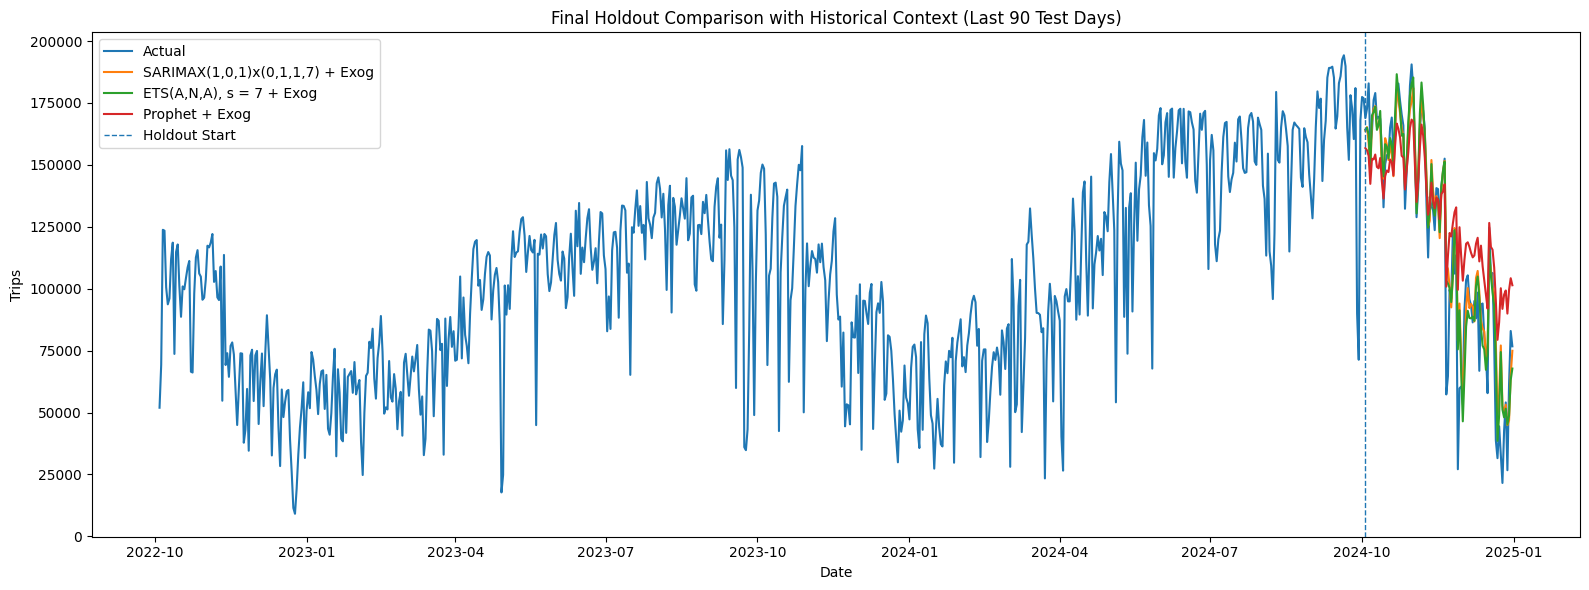

In [52]:
HOLDOUT_DAYS = len(holdout)
CONTEXT_DAYS = 365 * 2

holdout_idx = pd.to_datetime(holdout.index)
holdout_start = holdout_idx[0]
context_start = holdout_start - pd.Timedelta(days=CONTEXT_DAYS)

full_series = pd.concat([train, val, test], axis=0).copy()
full_series.index = pd.to_datetime(full_series.index)

plot_df = full_series.loc[context_start:]

def _check_len(name, arr, n):
    arr = np.asarray(arr).reshape(-1)
    if len(arr) != n:
        raise ValueError(f"{name} length mismatch: expected {n}, got {len(arr)}.")
    return arr

sarima_preds  = _check_len("sarima_preds", sarima_preds, HOLDOUT_DAYS)
etsx_preds    = _check_len("etsx_preds", etsx_preds, HOLDOUT_DAYS)
prophet_preds = _check_len("prophet_preds", prophet_preds, HOLDOUT_DAYS)

# Plot
plt.figure(figsize=(16, 6))

# Actual demand over context window
plt.plot(
    plot_df.index,
    plot_df[TARGET_COL].astype(float).to_numpy(),
    linewidth=1.5,
    label="Actual"
)

# Forecasts only over holdout window
plt.plot(holdout_idx, sarima_preds,  linewidth=1.5, label="SARIMAX(1,0,1)x(0,1,1,7) + Exog")
plt.plot(holdout_idx, etsx_preds,    linewidth=1.5, label="ETS(A,N,A), s = 7 + Exog")
plt.plot(holdout_idx, prophet_preds, linewidth=1.5, label="Prophet + Exog")

# Holdout boundary
plt.axvline(holdout_start, linestyle="--", linewidth=1, label="Holdout Start")

plt.title(f"Final Holdout Comparison with Historical Context (Last {HOLDOUT_DAYS} Test Days)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.tight_layout()
plt.show()

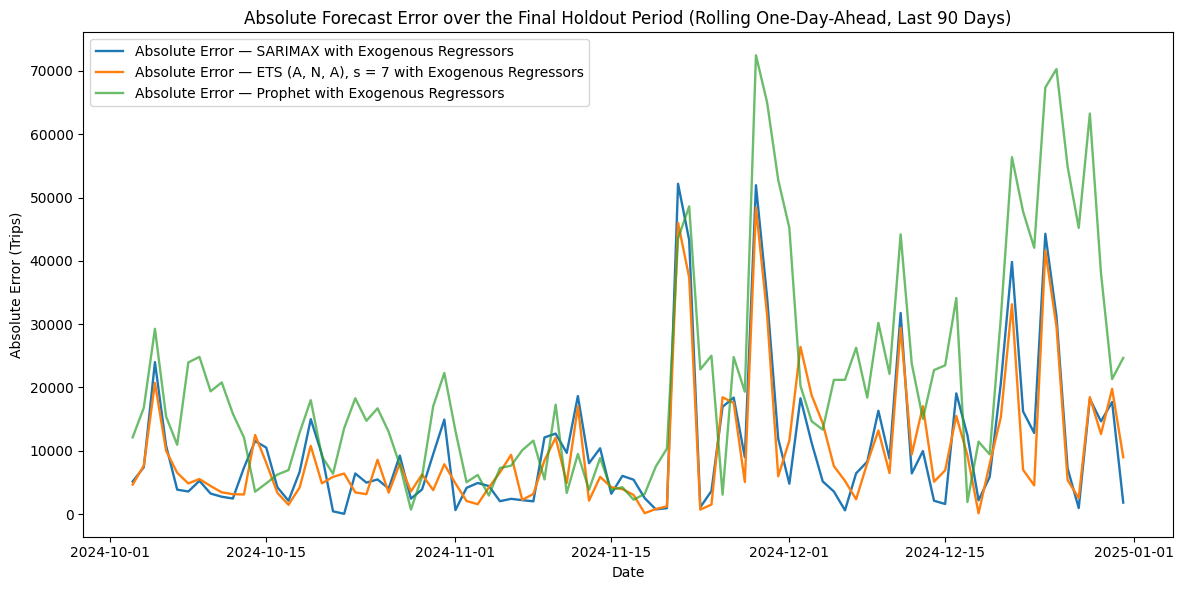

In [53]:
holdout_idx = pd.to_datetime(holdout.index)
y_true = holdout[TARGET_COL].astype(float).to_numpy()

H = len(holdout_idx)
sarima = np.asarray(sarima_preds).reshape(-1)
etsx   = np.asarray(etsx_preds).reshape(-1)
prop   = np.asarray(prophet_preds).reshape(-1)

if not (len(y_true) == len(sarima) == len(etsx) == len(prop) == H):
    raise ValueError("Length mismatch among holdout actuals and prediction arrays.")

abs_err_sarima = np.abs(y_true - sarima)
abs_err_etsx   = np.abs(y_true - etsx)
abs_err_prop   = np.abs(y_true - prop)

plt.figure(figsize=(12, 6))
plt.plot(holdout_idx, abs_err_sarima, linewidth=1.7, label="Absolute Error — SARIMAX with Exogenous Regressors")
plt.plot(holdout_idx, abs_err_etsx,   linewidth=1.7, label="Absolute Error — ETS (A, N, A), s = 7 with Exogenous Regressors")
plt.plot(holdout_idx, abs_err_prop,   linewidth=1.7, alpha=0.7, label="Absolute Error — Prophet with Exogenous Regressors")

plt.title(f"Absolute Forecast Error over the Final Holdout Period (Rolling One-Day-Ahead, Last {H} Days)")
plt.xlabel("Date")
plt.ylabel("Absolute Error (Trips)")
plt.legend()
plt.tight_layout()
plt.show()

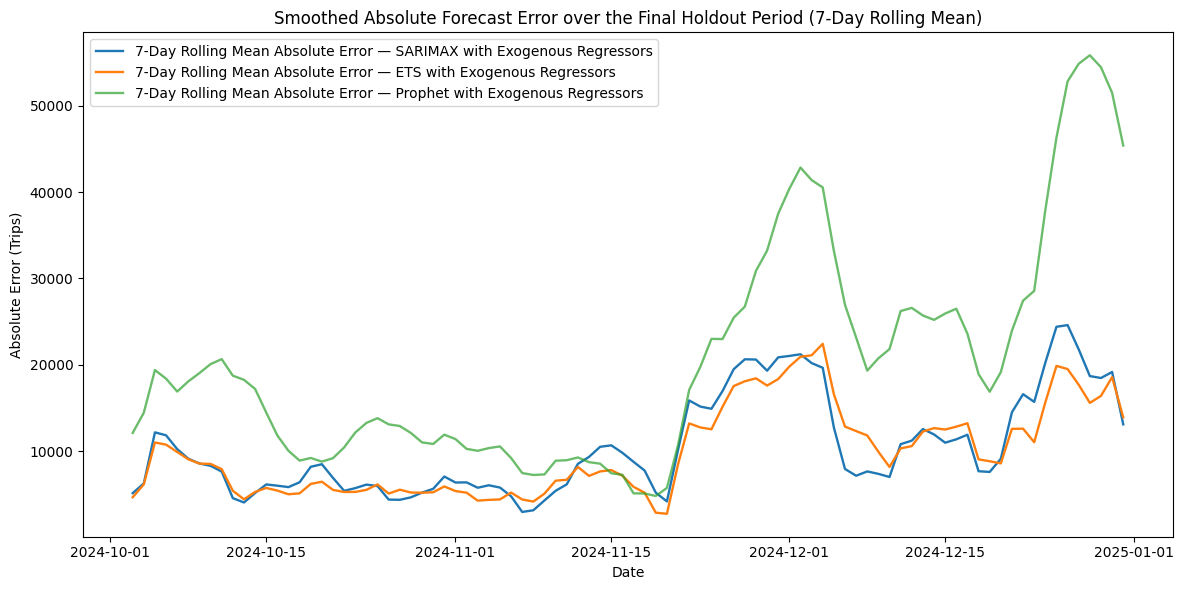

In [54]:
err_df = pd.DataFrame({
    "SARIMAX + exog": abs_err_sarima,
    "ETS + exog": abs_err_etsx,
    "Prophet + exog": abs_err_prop,
}, index=holdout_idx)

err_rm7 = err_df.rolling(7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(err_rm7.index, err_rm7["SARIMAX + exog"], linewidth=1.7, label="7-Day Rolling Mean Absolute Error — SARIMAX with Exogenous Regressors")
plt.plot(err_rm7.index, err_rm7["ETS + exog"], linewidth=1.7, label="7-Day Rolling Mean Absolute Error — ETS with Exogenous Regressors")
plt.plot(err_rm7.index, err_rm7["Prophet + exog"], linewidth=1.7, alpha=0.7, label="7-Day Rolling Mean Absolute Error — Prophet with Exogenous Regressors")

plt.title("Smoothed Absolute Forecast Error over the Final Holdout Period (7-Day Rolling Mean)")
plt.xlabel("Date")
plt.ylabel("Absolute Error (Trips)")
plt.legend()
plt.tight_layout()
plt.show()